In [1]:
import os
import random
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                extract_gp_dict_from_collectri_tf_network,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                get_gene_annotations,
                                generate_enriched_gp_info_plots,
                                generate_multimodal_mapping_dict,
                                get_unique_genes_from_gp_dict)

/cluster/project/moor/lynn/micromamba/envs/nichecompass_env_new/lib/python3.9/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/cluster/project/moor/lynn/micromamba/envs/nichecompass_env_new/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
### Dataset ###
dataset = "run2_3_codex_raw_xenium_norm100_log_scale_16_umap_leiden_0_7"
species = "human"
spatial_key = "spatial"
n_neighbors = 4
n_sampled_neighbors = 4
filter_genes = False
filter_peaks = False

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "xenium_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.01
conv_layer_encoder = "gatv2conv" # change to "gcnconv" if not enough compute and memory

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 300.
lambda_l1_masked = 0. # prior GP  regularization
lambda_l1_addon = 30. # de novo GP regularization
edge_batch_size = 256 # increase if more memory available or decrease to save memory
use_cuda_if_available = True

### Analysis ###
cell_type_key = "annotation"
latent_leiden_resolution = 0.2
latent_cluster_key = f"nichecompass_latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "slide_str"
spot_size = 10
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

## Load model

In [3]:
figure_folder_path = 'final/figures'
model_folder_path = 'final/model'

In [4]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata_leiden_02_differential_gps.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 439, n_cat_covariates_embed_input: 0, n_hidden: 216, n_latent: 116, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 116, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 439
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 116, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 439


## Identify Niches

In [5]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [6]:
sc.settings.set_figure_params(figsize=(6, 6), dpi_save=400, frameon= False)

<Figure size 960x1120 with 0 Axes>

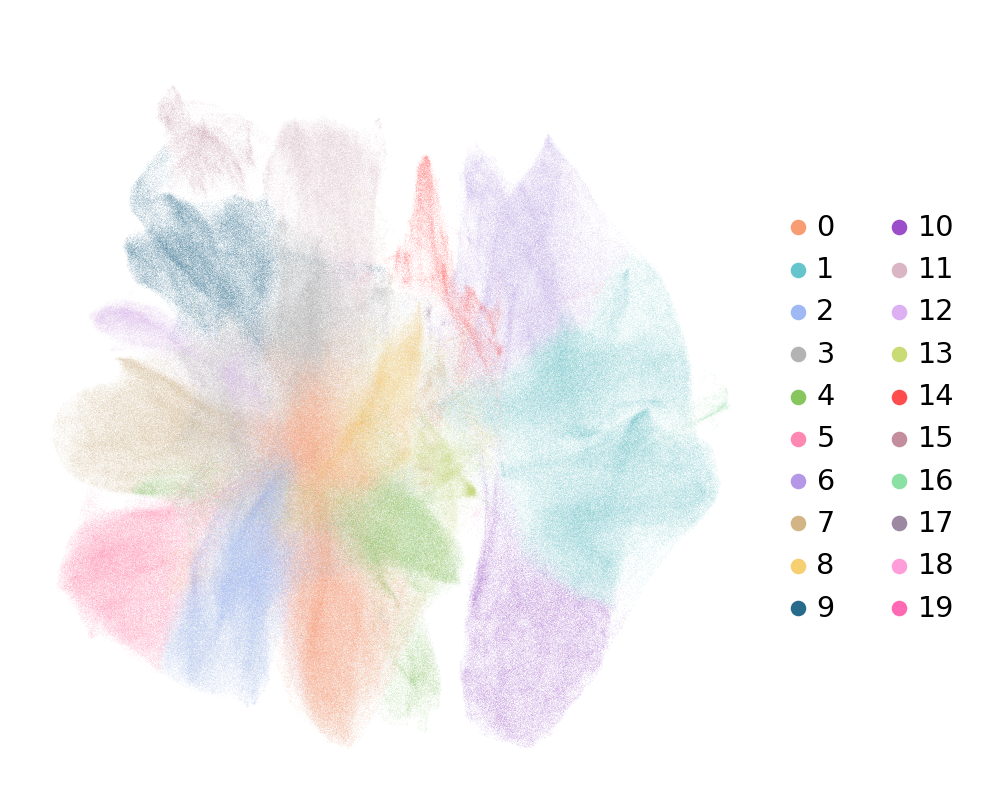

<Figure size 480x480 with 0 Axes>

In [13]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space_overlayed_numbers.png"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)

sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f" ",
           save = '_NEW_res_02_new_annotation_niches_in_latent_space.png',
           show=True)

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path, bbox_inches="tight")
plt.show()

<Figure size 960x1120 with 0 Axes>

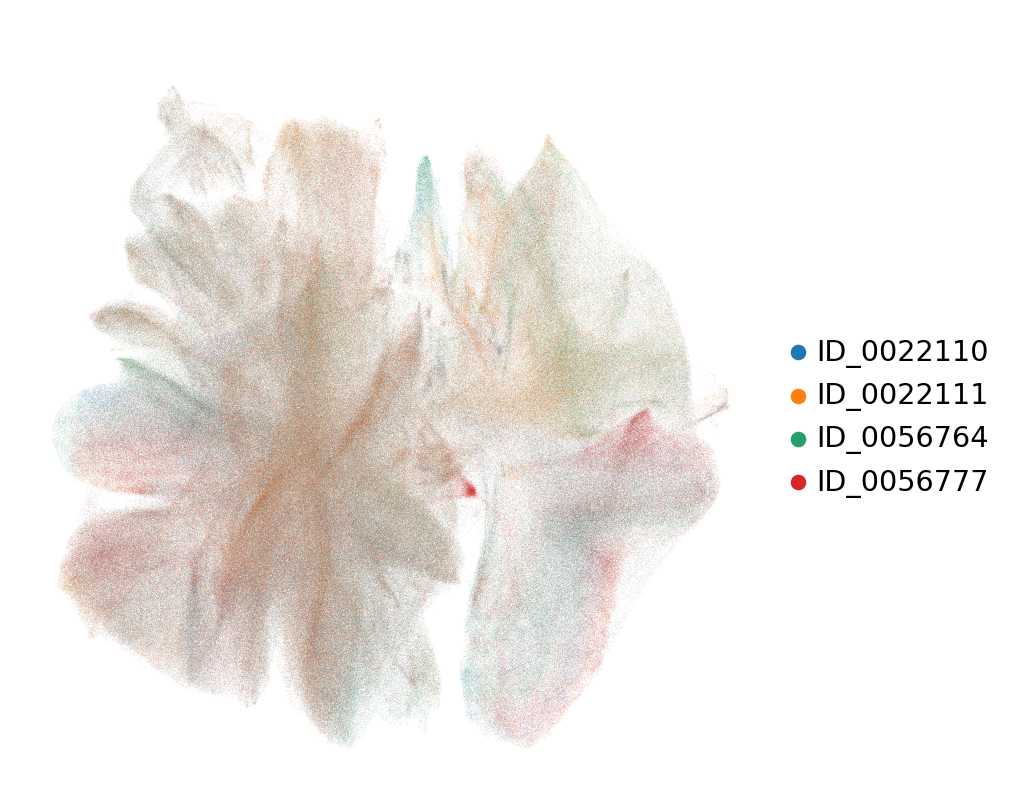

<Figure size 480x480 with 0 Axes>

In [11]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "slide_str_latent_physical_space_.png"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Batches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)

sc.pl.umap(adata=model.adata,
           color=['slide_str'],
           groups=groups,
           title=f" ",
           save = '_NEW_res_02_new_annotation_batches_in_latent_space.png',
           show=True)

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path, bbox_inches="tight")
plt.show()

In [14]:
sc.set_figure_params(figsize=(6, 6), frameon=False, dpi_save=400, )
sns.set_theme()
save_dir = './'

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [8]:
cluster_colors=create_new_color_dict(
    adata=model.adata,
    cat_key='niche_annotation')

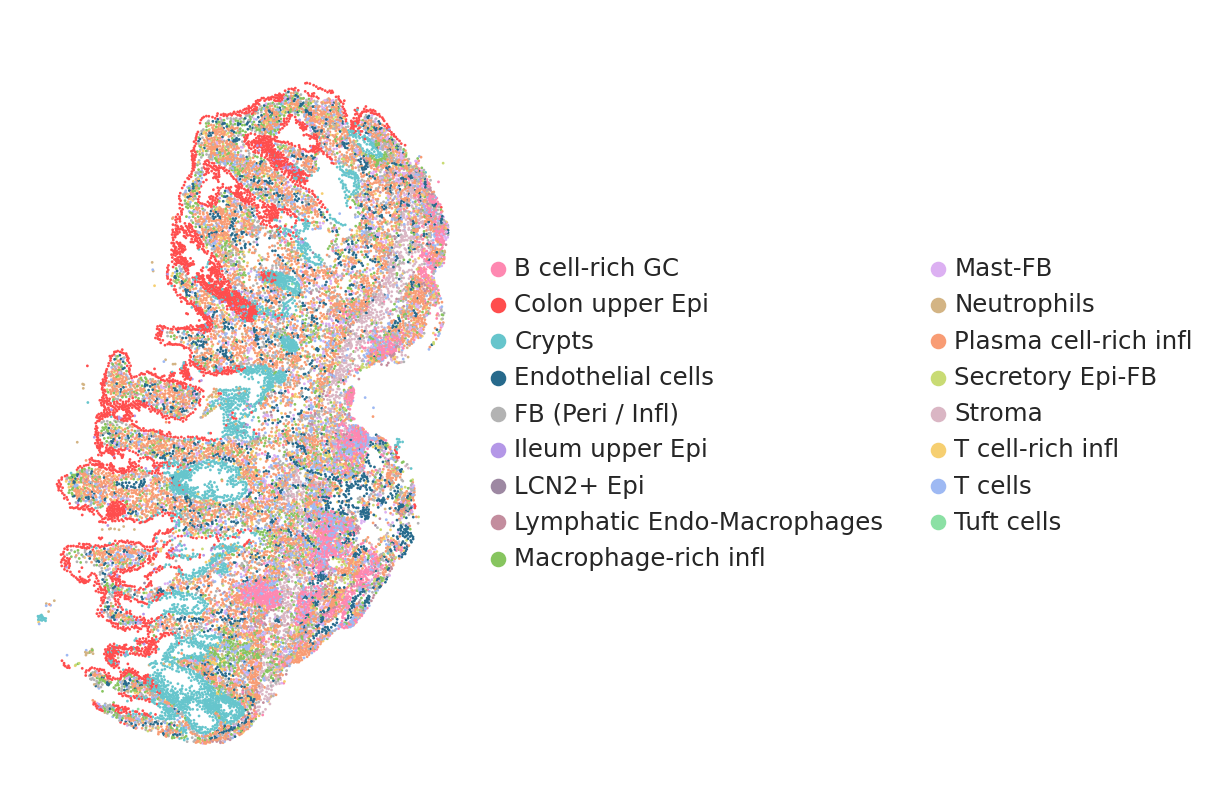

In [55]:

sc.pl.spatial(adata=model.adata[(model.adata.obs['core_ID'] == 'X1Y1') & (model.adata.obs['slide_str'] == 'ID_0056764')],
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  title=' ',
                  save = '_NEW_res_02_new_annotation_niches_R_colon_T1.png',
                  show=True)

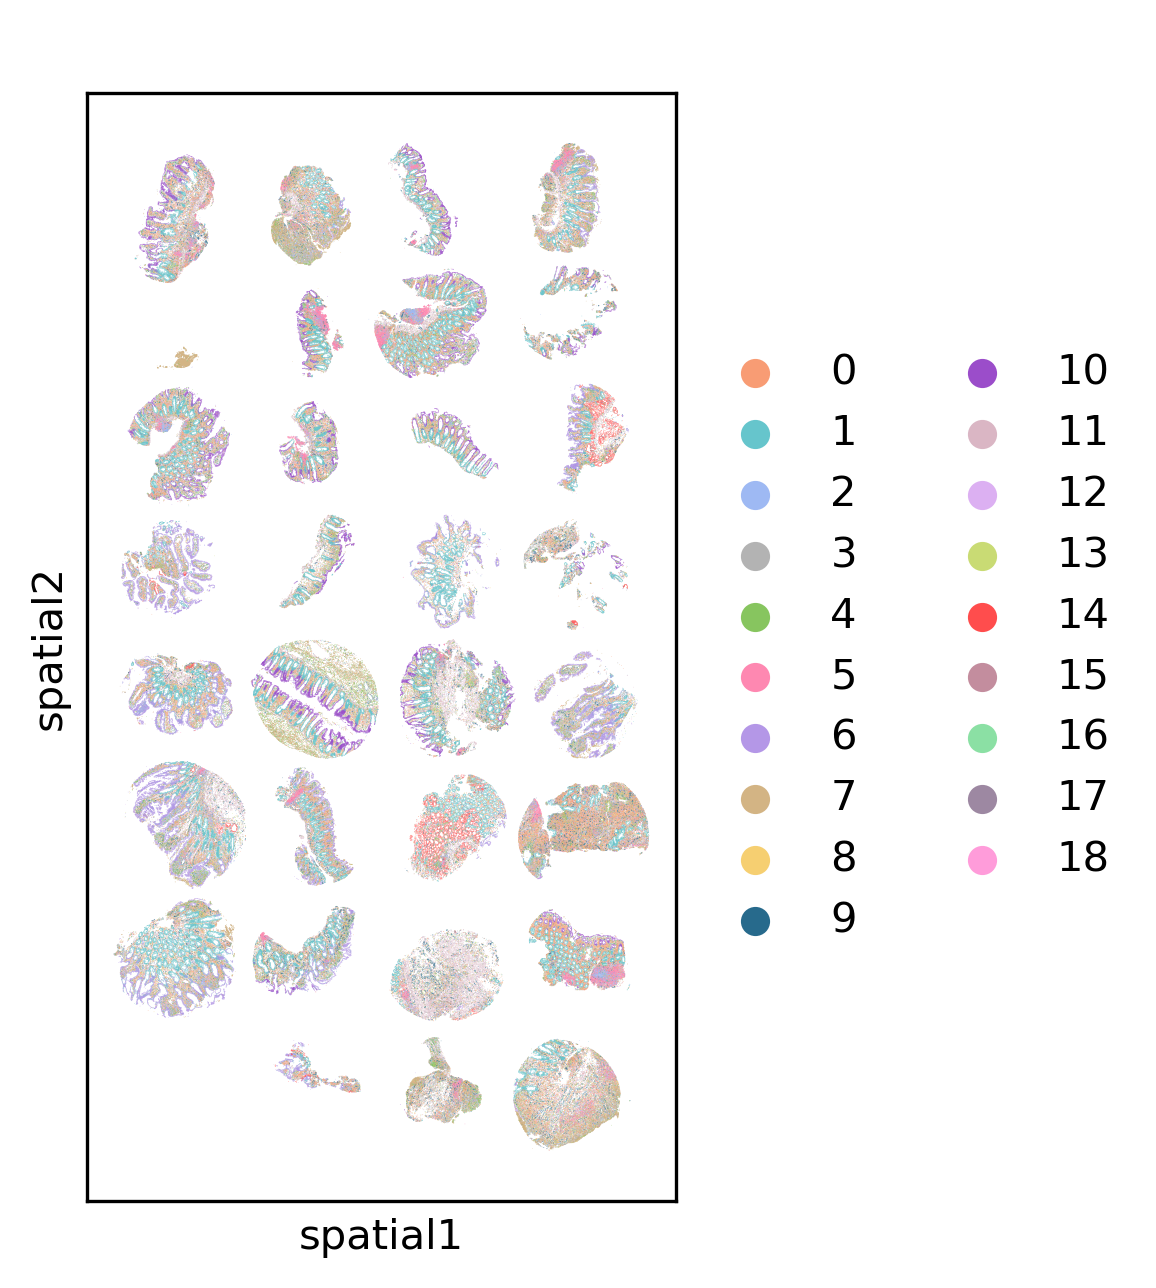

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
sc.pl.spatial(adata=model.adata[model.adata.obs['slide_str'] == 'ID_0056764'],
                  color=[latent_cluster_key],
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=' ',
                  save = '_NEW_res_02_new_annotation_niches_id_56764.png',
                  show=True)

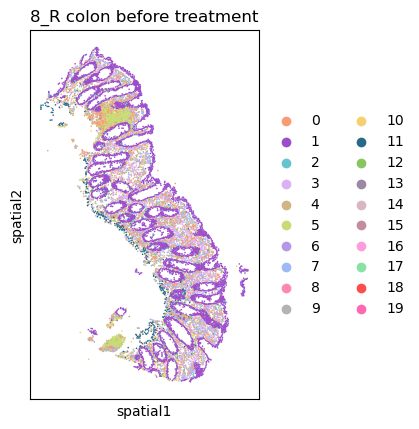

In [14]:
sc.pl.spatial(adata=model.adata[(model.adata.obs['core_ID'] == 'X3Y1') & (model.adata.obs['slide_str'] == 'ID_0056764')],
                  color=[latent_cluster_key],
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title='8_R colon before treatment',
                  save = '_res_02_new_annotation_niches_ID_56764_X3Y1.png',
                  show=True)

In [81]:
adata_tmp = model.adata[(model.adata.obs['core_ID'] == 'X3Y1') & (model.adata.obs['slide_str'] == 'ID_0056764')]
coords = adata_tmp.obsm['spatial']

# Get min and max for x and y
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")

x_min: 5535.9765625, x_max: 6833.6455078125
y_min: 84.5393295288086, y_max: 2178.714111328125


In [87]:
size = 1200       # side length of the square
x_offset = 200    # move right from the left edge
y_offset = 900    # move down from the top edge

# Compute crop coordinates
x_min_crop = 5536 + x_offset
x_max_crop = x_min_crop + size

y_max_crop = 2178 - y_offset
y_min_crop = y_max_crop - size

# Create mask
coords = adata_tmp.obsm['spatial']
mask = (
    (coords[:, 0] >= x_min_crop) & (coords[:, 0] <= x_max_crop) &
    (coords[:, 1] >= y_min_crop) & (coords[:, 1] <= y_max_crop)
)

# Crop AnnData
adata_cropped = adata_tmp[mask].copy()

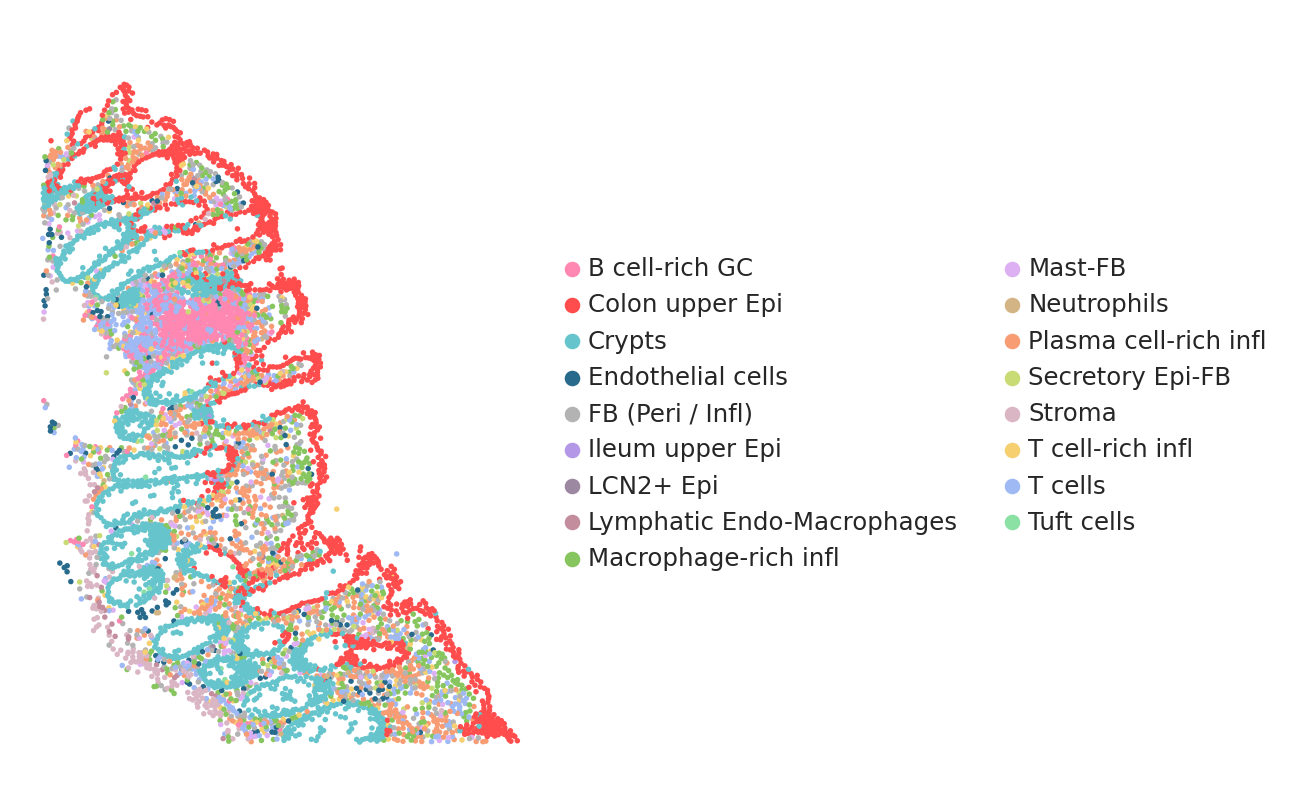

In [88]:
sc.pl.spatial(adata=adata_cropped,
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  title=' ',
                  save = '_R_colon_t1_cropped.png',
                  show=True)

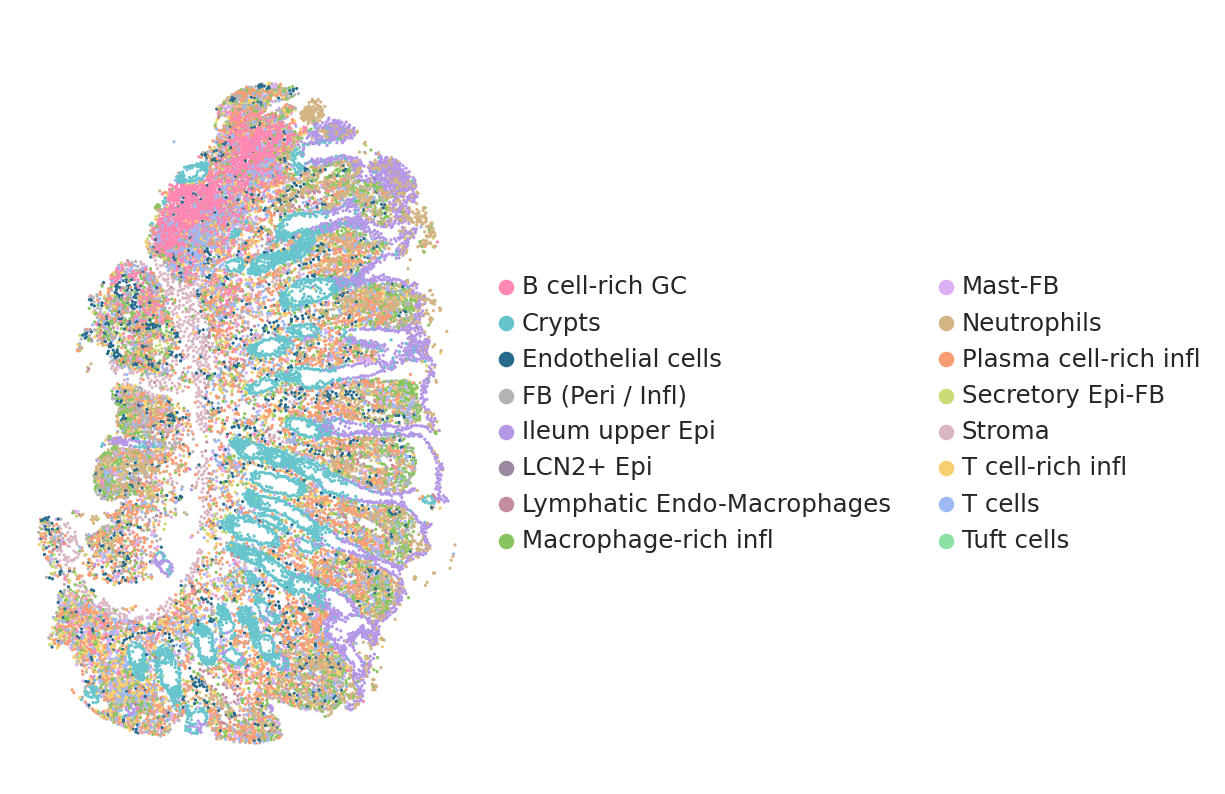

In [70]:
sc.pl.spatial(adata=model.adata[(model.adata.obs['core_ID'] == 'X4Y1') & (model.adata.obs['slide_str'] == 'ID_0056764')],
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  save='ileum_t1_R.png',
                  title = ' ',
                  show=True)

In [66]:
adata_tmp = model.adata[(model.adata.obs['core_ID'] == 'X4Y1') & (model.adata.obs['slide_str'] == 'ID_0056764')]
coords = adata_tmp.obsm['spatial']

# Get min and max for x and y
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")

x_min: 8226.7392578125, x_max: 9514.828125
y_min: 78.21395111083984, y_max: 2120.262451171875


In [78]:
size = 1200       # side length of the square
x_offset = 500    # move right from the left edge
y_offset = 1000    # move down from the top edge

# Compute crop coordinates
x_min_crop = 8226.8 + x_offset
x_max_crop = x_min_crop + size

y_max_crop = 2120 - y_offset
y_min_crop = y_max_crop - size

# Create mask
coords = adata_tmp.obsm['spatial']
mask = (
    (coords[:, 0] >= x_min_crop) & (coords[:, 0] <= x_max_crop) &
    (coords[:, 1] >= y_min_crop) & (coords[:, 1] <= y_max_crop)
)

# Crop AnnData
adata_cropped = adata_tmp[mask].copy()

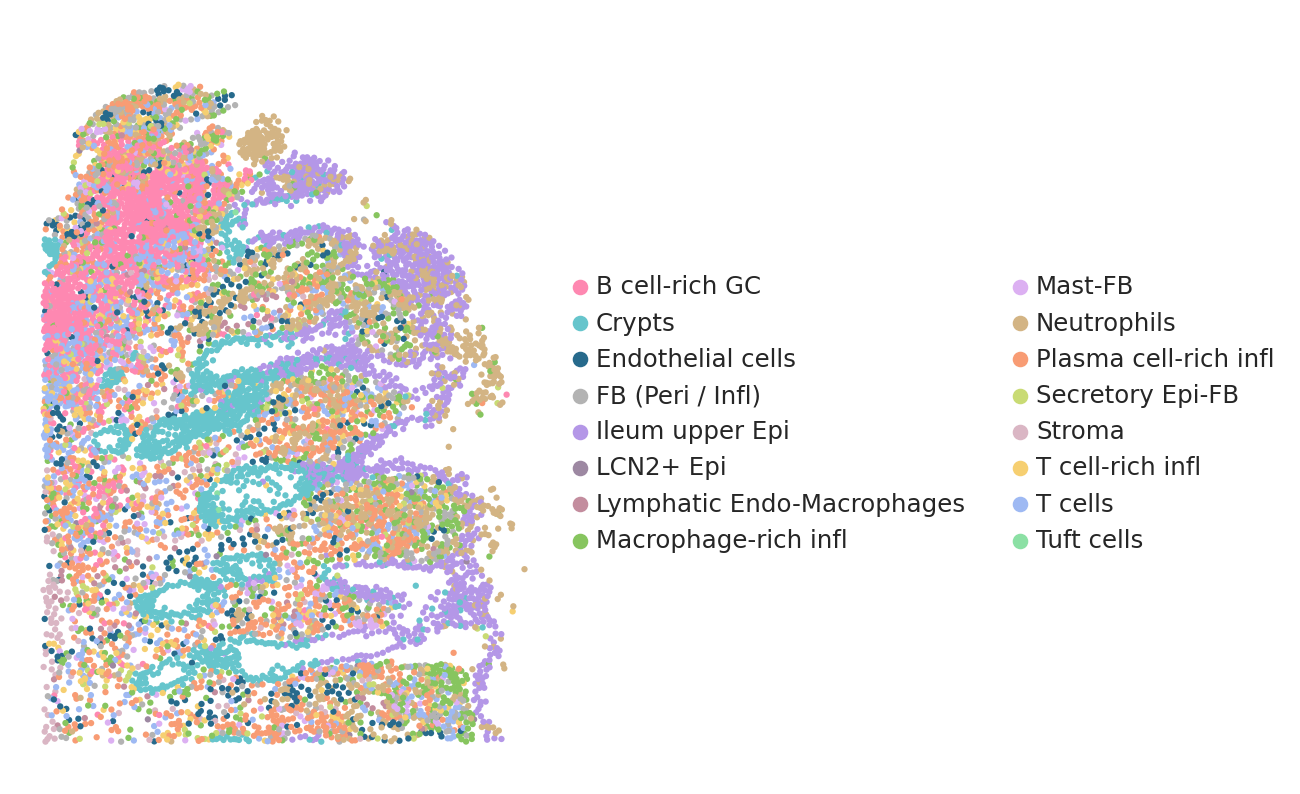

In [79]:
sc.pl.spatial(adata=adata_cropped,
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  save='ileum_t1_R_cropped.png',
                  title = ' ',
                  show=True)

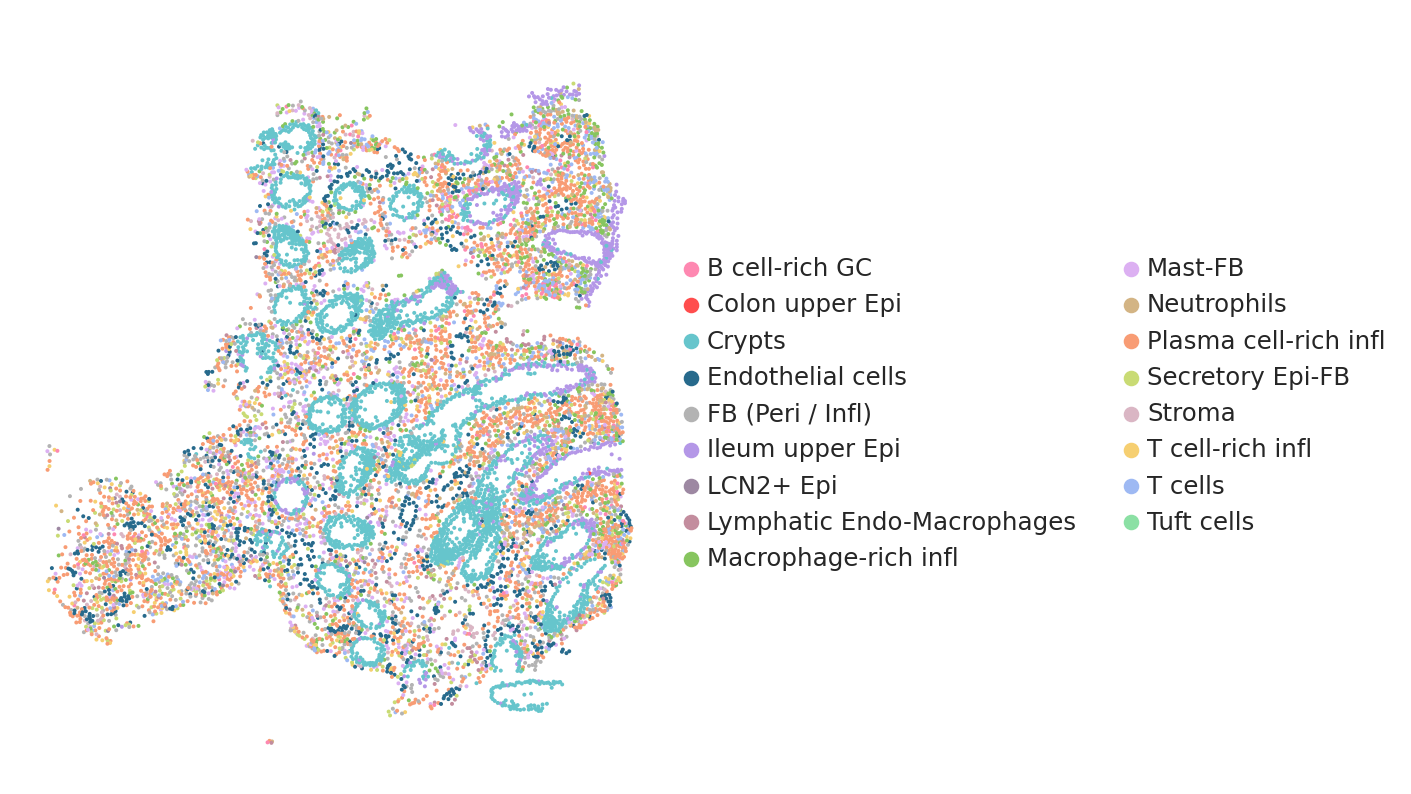

In [56]:
sc.pl.spatial(adata=model.adata[(model.adata.obs['core_ID'] == 'X1Y1') & (model.adata.obs['slide_str'] == 'ID_0056777')],
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  title=' ',
                  save = '_NEW_res_02_new_annotation_niches_NR_ileum_T1.png',
                  show=True)

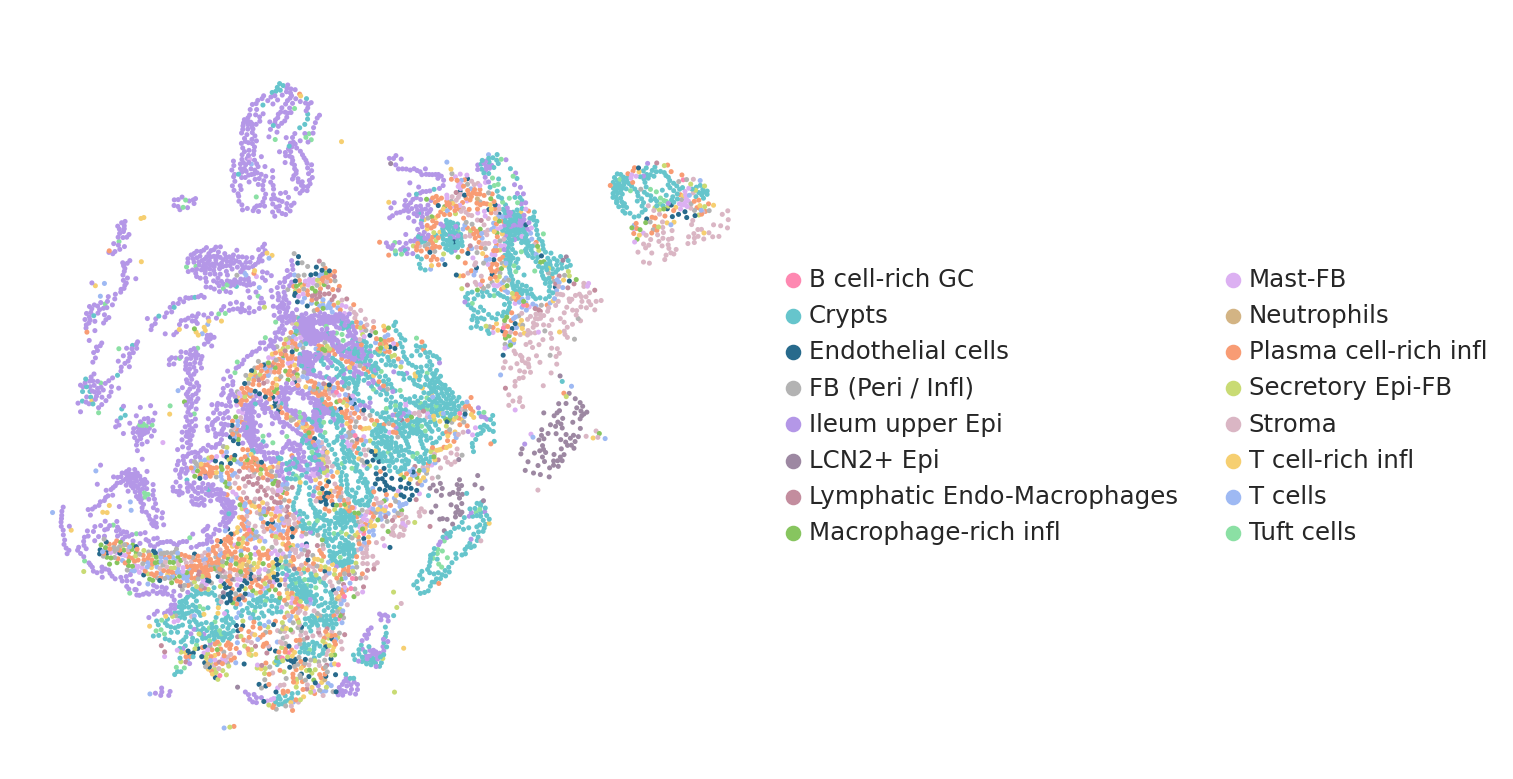

In [60]:
sc.pl.spatial(adata=model.adata[(model.adata.obs['core_ID'] == 'X1Y3') & (model.adata.obs['slide_str'] == 'ID_0022111')],
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=8,
                  title=' ',
                  save = '_NEW_res_02_new_annotation_niches_NR_ileum_T2_same_patient.png',
                  show=True)

In [89]:
adata_tmp = model.adata[(model.adata.obs['core_ID'] == 'X4Y2') & (model.adata.obs['slide_str'] == 'ID_0022111')]
coords = adata_tmp.obsm['spatial']

# Get min and max for x and y
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")

x_min: 10657.314331054688, x_max: 12675.071533203125
y_min: 2997.400390625, y_max: 4986.79736328125


In [92]:
size = 1200       # side length of the square
x_offset = 500    # move right from the left edge
y_offset = 1000    # move down from the top edge

# Compute crop coordinates
x_min_crop = 10657.32 + x_offset
x_max_crop = x_min_crop + size

y_max_crop = 4986 - y_offset
y_min_crop = y_max_crop - size

# Create mask
coords = adata_tmp.obsm['spatial']
mask = (
    (coords[:, 0] >= x_min_crop) & (coords[:, 0] <= x_max_crop) &
    (coords[:, 1] >= y_min_crop) & (coords[:, 1] <= y_max_crop)
)

# Crop AnnData
adata_cropped = adata_tmp[mask].copy()

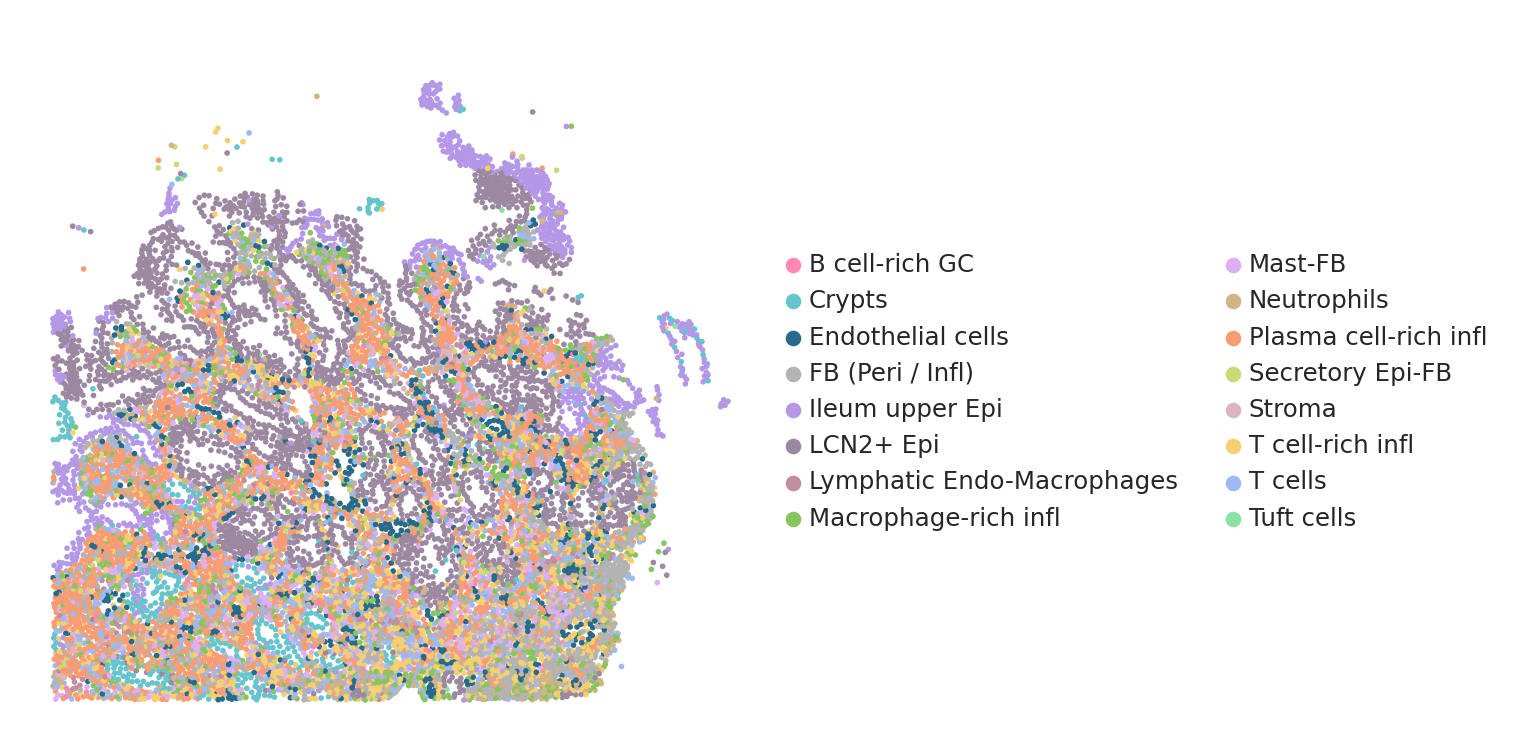

In [94]:
sc.pl.spatial(adata=adata_cropped,
                  color=['niche_annotation'],
                  palette=cluster_colors,
                  spot_size=spot_size,
                  title=' ',
                  save = '_ileum_NR_t2.png',
                  show=True)

#### Niche Composition

In [22]:
model.adata.obs["annotation"] = model.adata.obs["annotation"].replace("Transit Amplifying Cells (Ileum)", "Other")

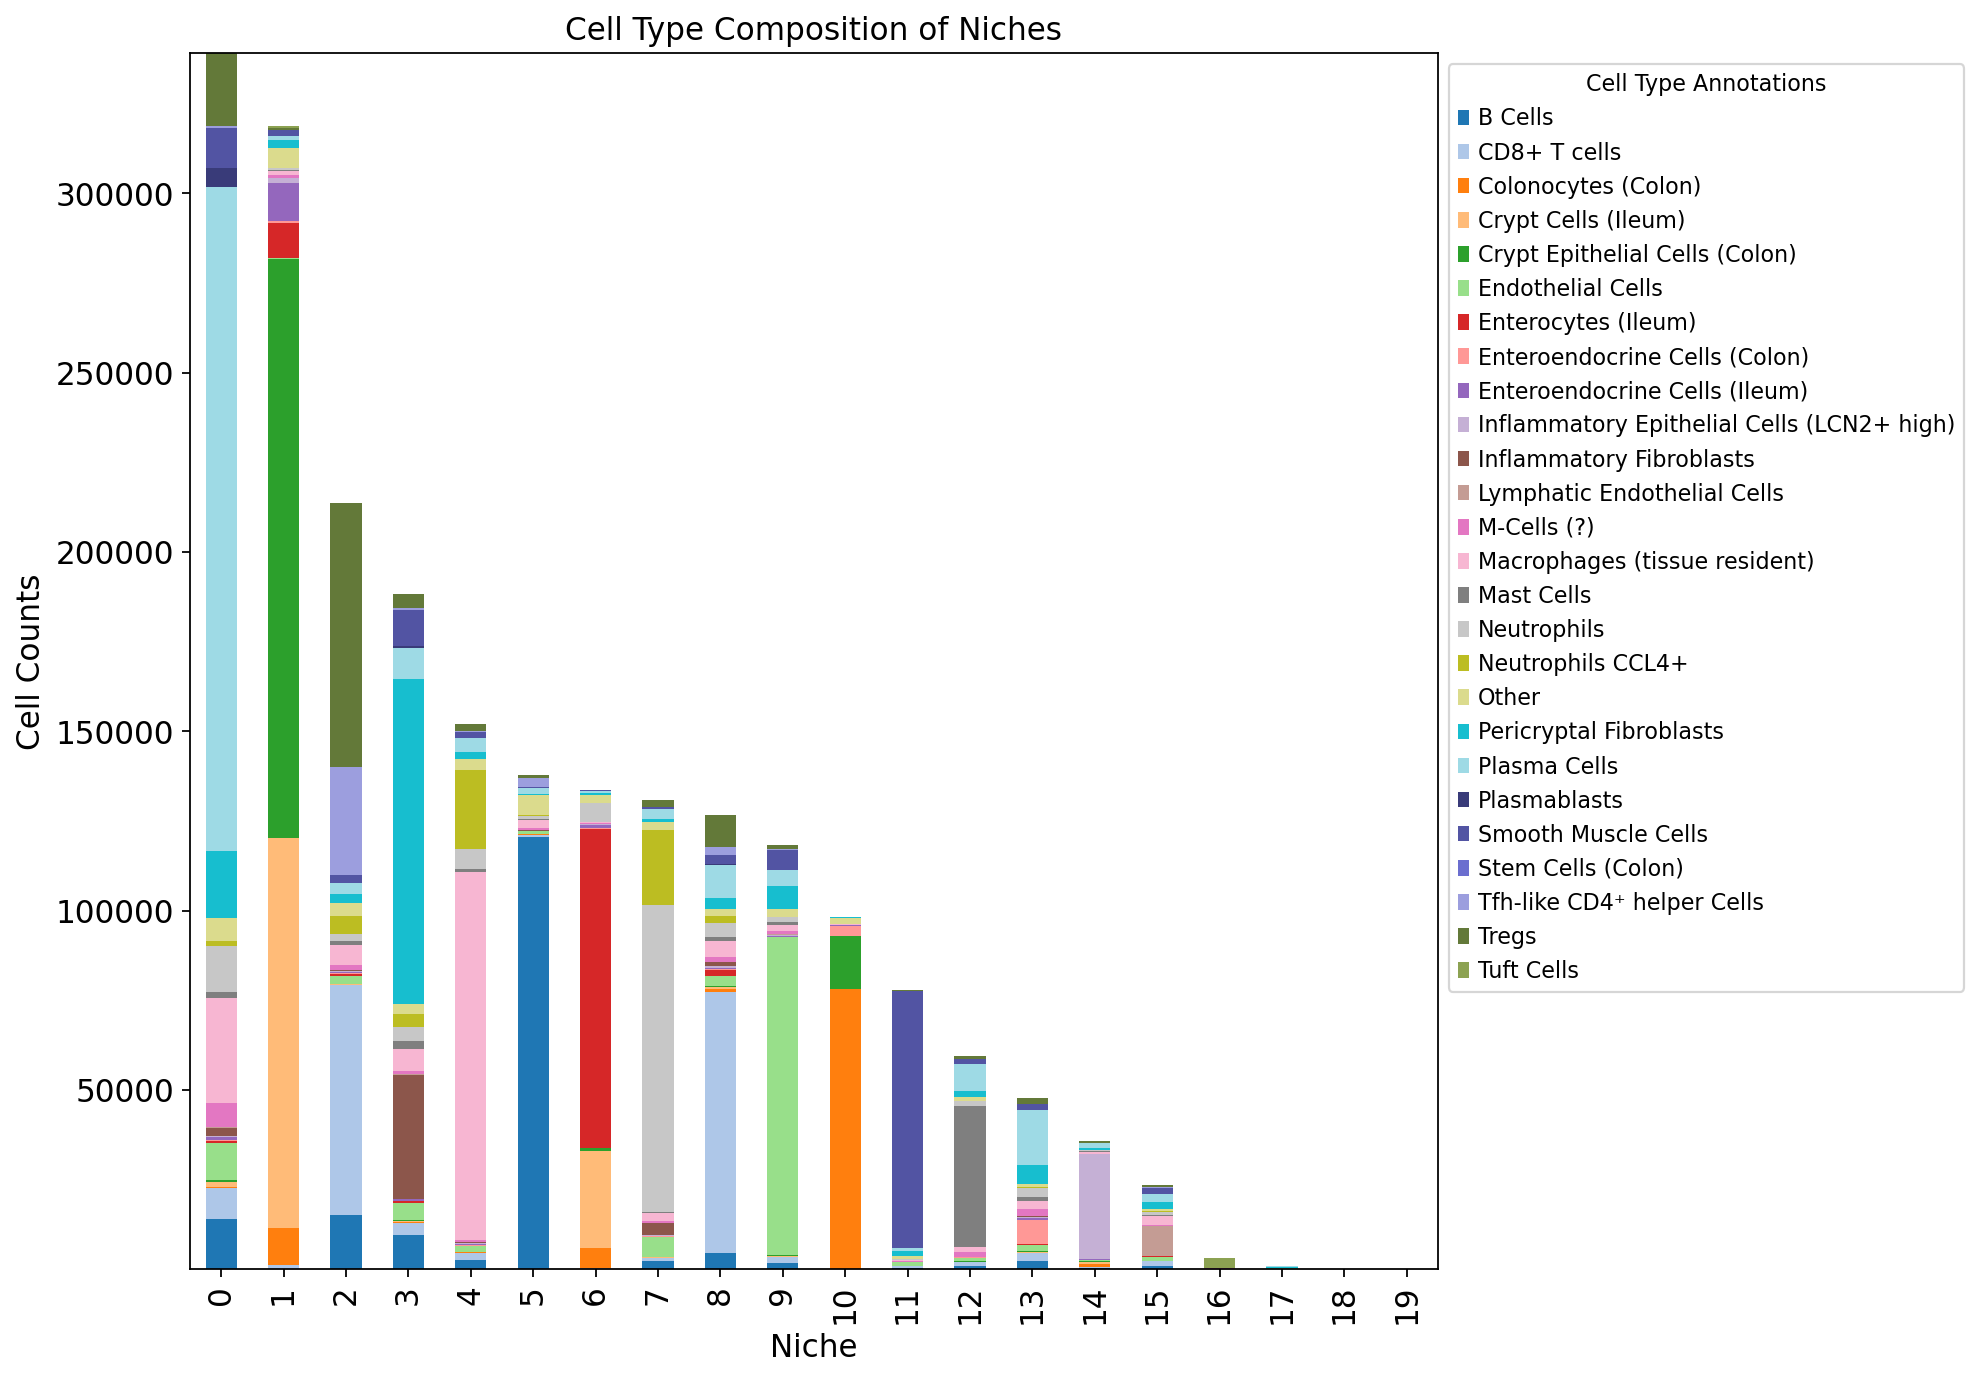

In [26]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.png"

import matplotlib.cm as cm

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())

num_cell_types = df_counts.shape[1]
cmap = cm.get_cmap("tab20")  # first 20
colors = list(cmap.colors)

# add more if needed
colors += list(cm.get_cmap("tab20b").colors)
colors += list(cm.get_cmap("tab20c").colors)

# truncate to needed length
colors = colors[:num_cell_types]

df_counts.plot(
    kind="bar",
    
    stacked=True,
    figsize=(10, 10),
    color=colors
)

legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
plt.grid(False)

if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight", dpi=400)

In [108]:
df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts['total']= df_counts.sum(axis=1)

df_counts

annotation                  B Cells  CD8+ T cells  Colonocytes (Colon)  \
niche_annotation                                                         
B cell-rich GC               120363           825                  109   
Colon upper Epi                   4            93                77982   
Crypts                          118          1127                10321   
Endothelial cells              1680          1697                   33   
FB (Peri / Infl)               9539          3352                  147   
Ileum upper Epi                  49           352                 5412   
LCN2+ Epi                       171           360                  889   
Lymphatic Endo-Macrophages      882          1277                    8   
Macrophage-rich infl           2578          1926                  166   
Mast-FB                         927           979                   15   
Neutrophils                    2164           907                  145   
Plasma cell-rich infl         13915          8792                  211   
Secretory Epi-FB               2369          2002                   52   
Stem cell region                  0             0                    2   
Stroma                          381           383                    0   
T cell-rich infl               4514         72801                  763   
T cells                       15196         64048                   86   
Tuft cells                        1             1                    1   

annotation                  Crypt Cells (Ileum)  \
niche_annotation                                  
B cell-rich GC                                9   
Colon upper Epi                              61   
Crypts                                   108595   
Endothelial cells                           236   
FB (Peri / Infl)                            425   
Ileum upper Epi                           27075   
LCN2+ Epi                                   642   
Lymphatic Endo-Macrophages                  108   
Macrophage-rich infl                        102   
Mast-FB                                     161   
Neutrophils                                 110   
Plasma cell-rich infl                      1445   
Secretory Epi-FB                            429   
Stem cell region                              1   
Stroma                                       54   
T cell-rich infl                            593   
T cells                                     159   
Tuft cells                                   30   

annotation                  Crypt Epithelial Cells (Colon)  Endothelial Cells  \
niche_annotation                                                                
B cell-rich GC                                          10                730   
Colon upper Epi                                      14646                 26   
Crypts                                              161666                152   
Endothelial cells                                      158              88754   
FB (Peri / Infl)                                       184               4639   
Ileum upper Epi                                        761                 96   
LCN2+ Epi                                              297                163   
Lymphatic Endo-Macrophages                              44               1178   
Macrophage-rich infl                                   106               1521   
Mast-FB                                                 52                971   
Neutrophils                                             43               5522   
Plasma cell-rich infl                                  649              10272   
Secretory Epi-FB                                       144               1718   
Stem cell region                                         2                  0   
Stroma                                                  27               1045   
T cell-rich infl                                       324               2678   
T cells                                 

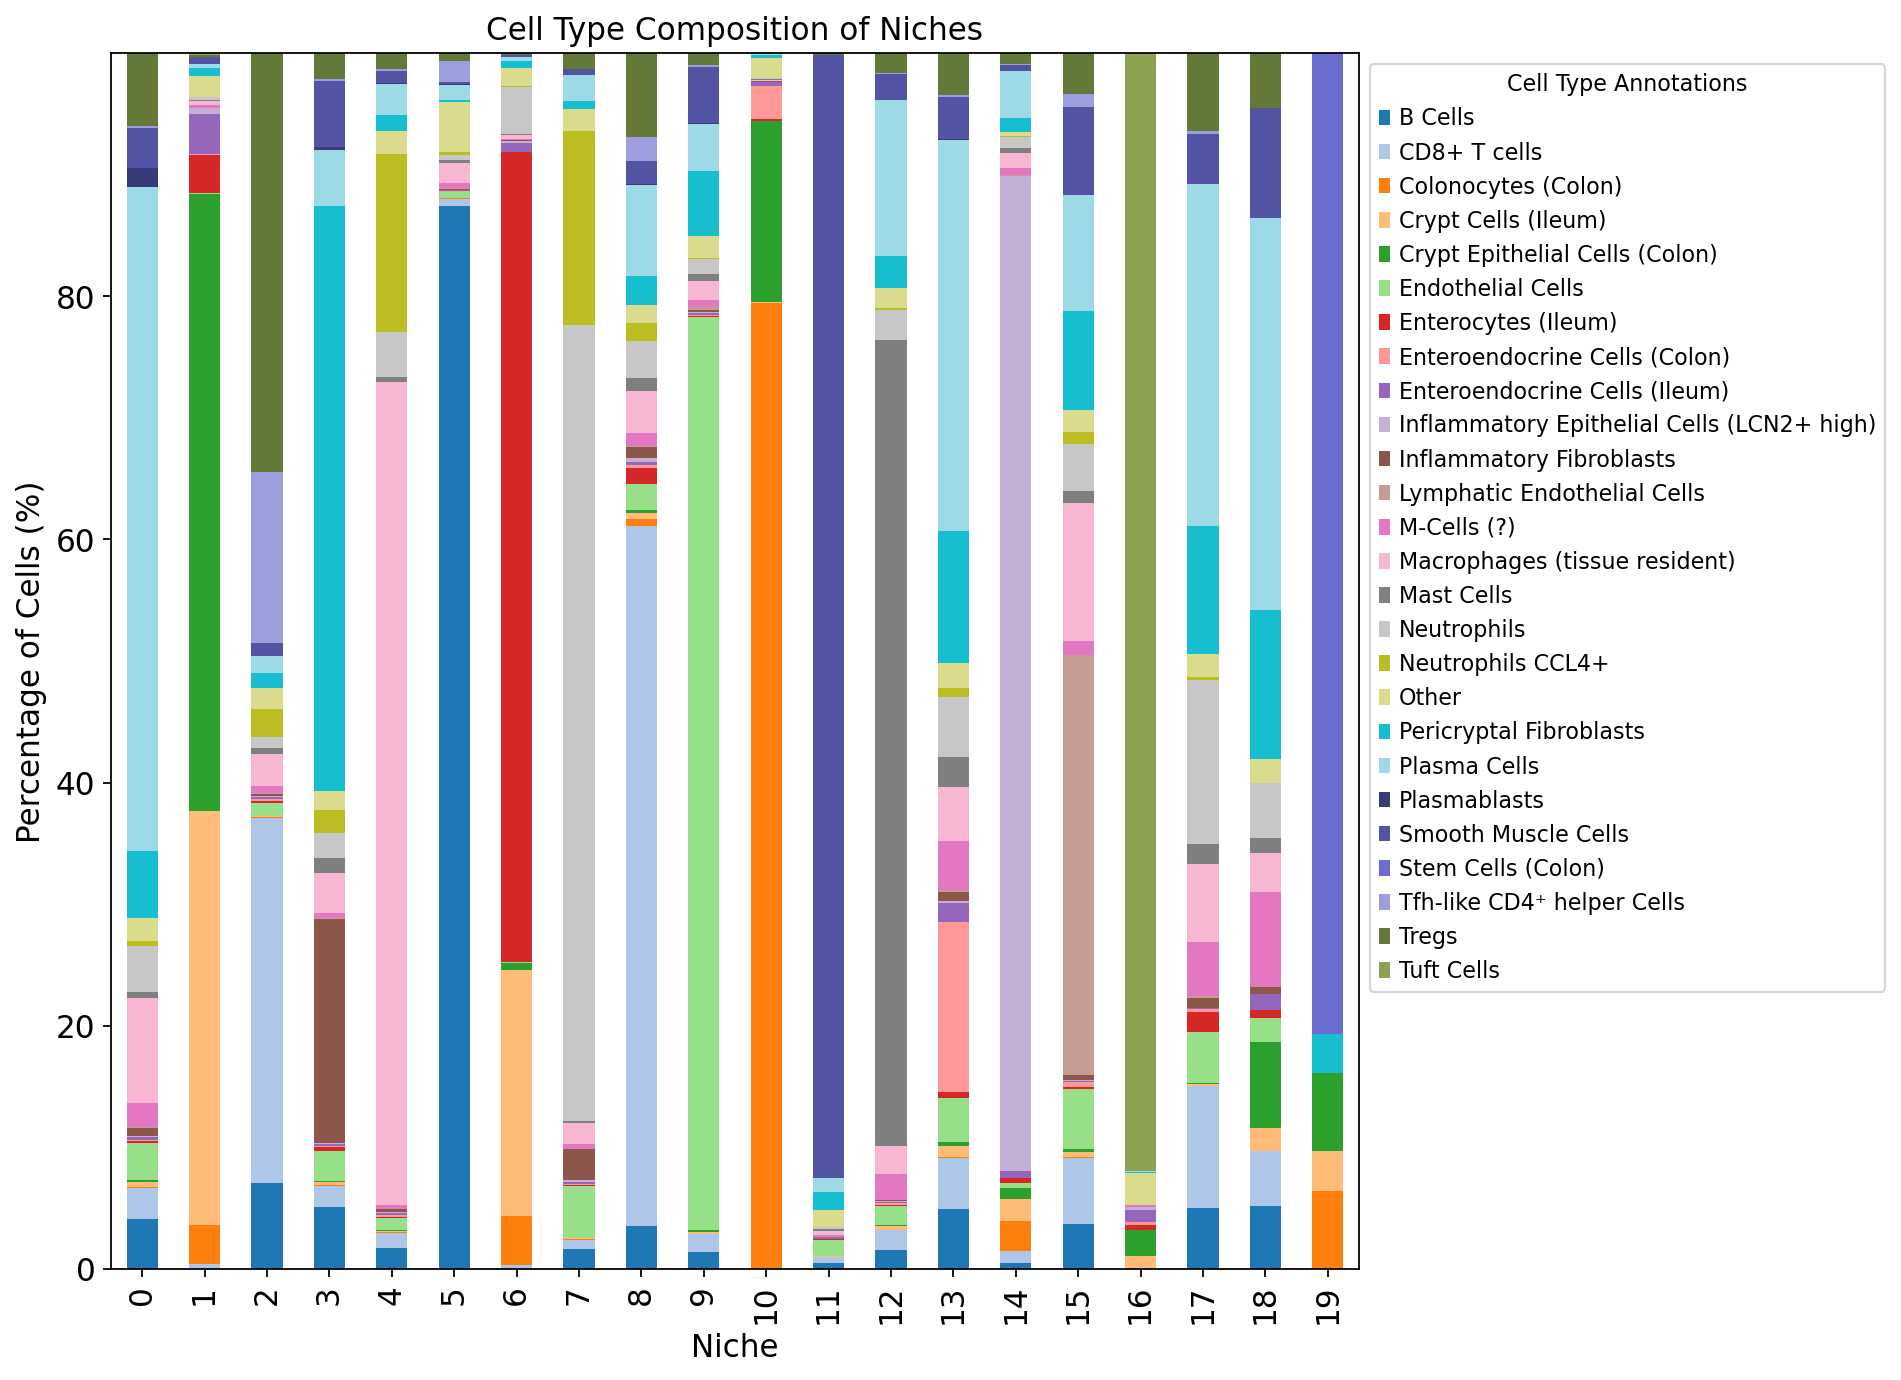

In [25]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition_percentages.png"

import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Compute counts per niche
df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())

# Convert counts to percentages per niche
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

num_cell_types = df_percent.shape[1]
cmap = cm.get_cmap("tab20")  # first 20 colors
colors = list(cmap.colors)

# add more if needed
colors += list(cm.get_cmap("tab20b").colors)
colors += list(cm.get_cmap("tab20c").colors)

# truncate to needed length
colors = colors[:num_cell_types]

# Plot stacked bar chart with percentages
df_percent.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 10),
    color=colors
)

legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Percentage of Cells (%)")
plt.grid(False)
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight", dpi=400)


In [7]:
# Make sure latent_cluster_key is string type
model.adata.obs[latent_cluster_key] = model.adata.obs[latent_cluster_key].astype(str)

# Your mapping dict with string keys and string values
mapping_dict = {
    "0": "Plasma cell-rich infl",
    "1": "Crypts",
    "2": "T cells",
    "3": "FB (Peri / Infl)",
    "4": "Macrophage-rich infl",
    "5": "B cell-rich GC",
    "6": "Ileum upper Epi",
    "7": "Neutrophils",
    "8": "T cell-rich infl",
    "9": "Endothelial cells",
    "10": "Colon upper Epi",
    "11": "Stroma",
    "12": "Mast-FB",
    "13": "Secretory Epi-FB",
    "14": "LCN2+ Epi",
    "15": "Lymphatic Endo-Macrophages",
    "16": "Tuft cells",
    "17": "Plasma cell-rich infl",
    "18": "Plasma cell-rich infl",
    "19": "Stem cell region"
}

# Map latent clusters to niche annotations
model.adata.obs['niche_annotation'] = model.adata.obs[latent_cluster_key].map(mapping_dict)


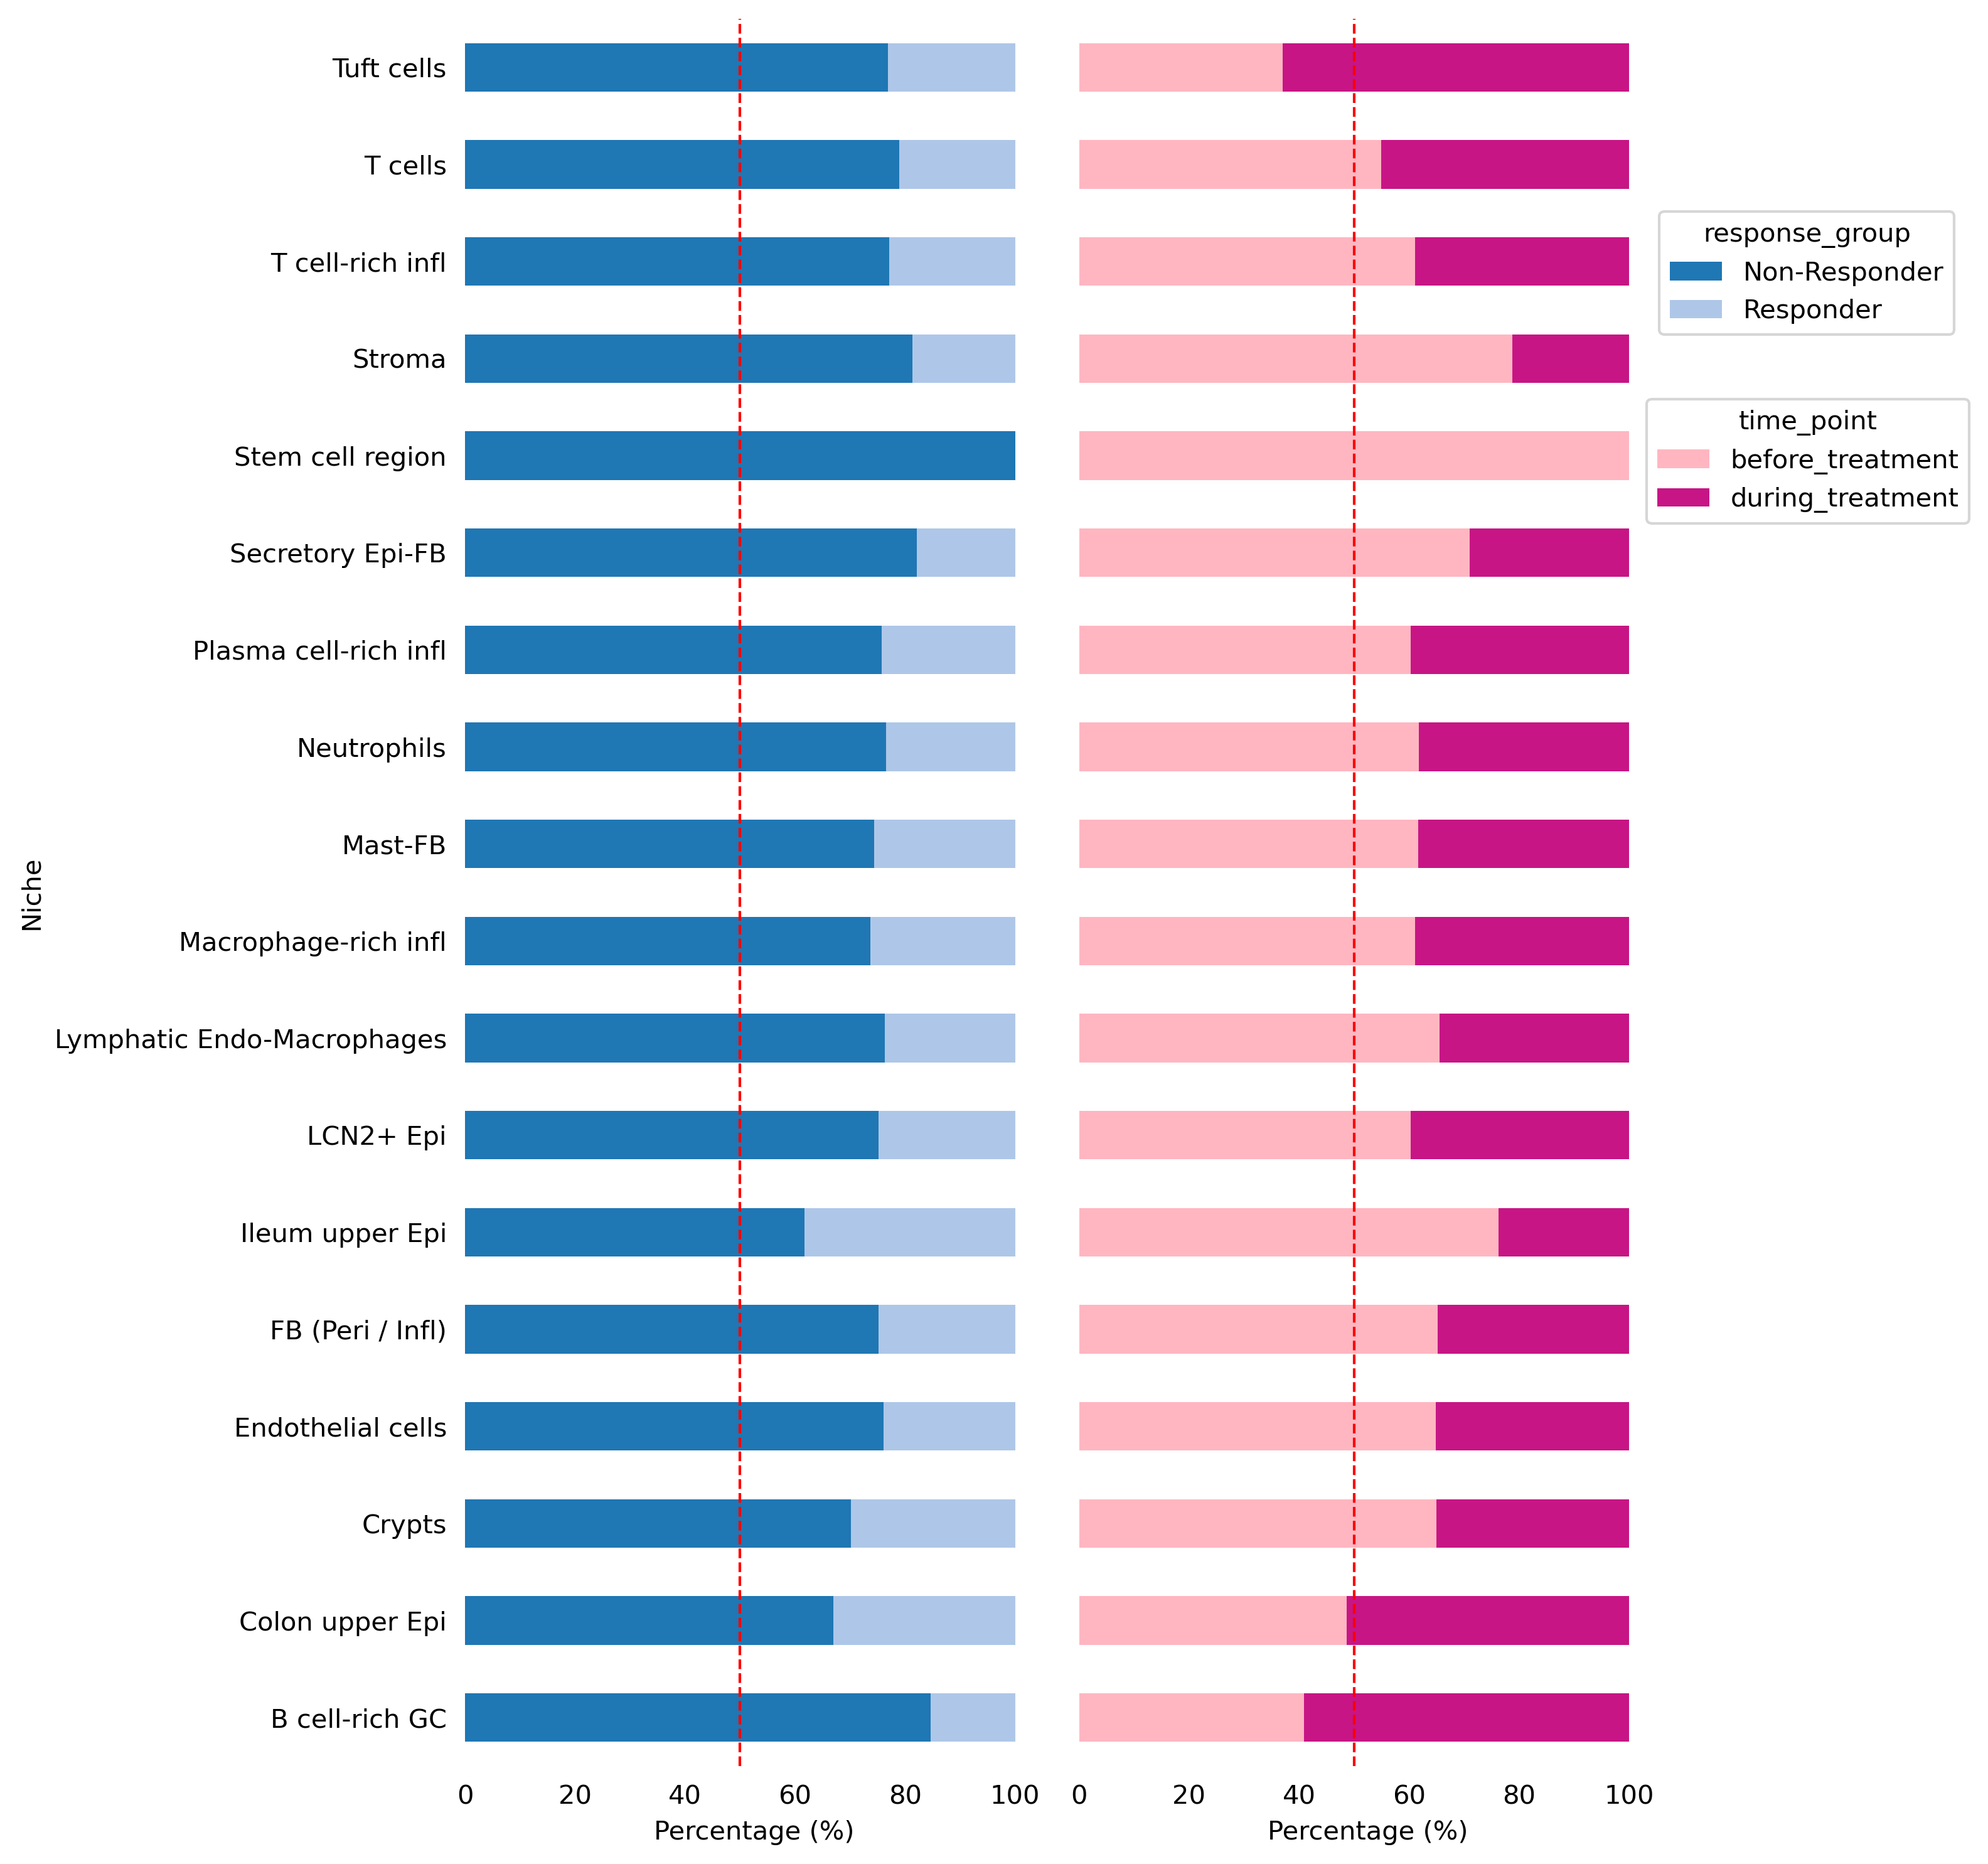

In [47]:
# Example metadata keys
metadata_key1 = 'response_group'
metadata_key2 = 'time_point'
latent_cluster_key = 'niche_annotation'

# Custom color palettes
cmap = cm.get_cmap("tab20")
colors_first = list(cmap.colors)
colors_second = ['#ffb6c1', '#c71585']     # lightpink, darkpink

# Compute percentages for both metadata
df_counts1 = model.adata.obs.groupby([latent_cluster_key, metadata_key1]).size().unstack(fill_value=0)
df_percent1 = df_counts1.div(df_counts1.sum(axis=1), axis=0) * 100

df_counts2 = model.adata.obs.groupby([latent_cluster_key, metadata_key2]).size().unstack(fill_value=0)
df_percent2 = df_counts2.div(df_counts2.sum(axis=1), axis=0) * 100

# Create figure with two plots side by side sharing the y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

# ---------- LEFT PLOT ----------
df_percent1.plot(
    kind='barh',
    stacked=True,
    ax=axes[0],
    color=colors_first[:df_percent1.shape[1]]
)
axes[0].axvline(50, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel("Percentage (%)")
axes[0].set_ylabel("Niche")
#axes[0].set_title(f"{metadata_key1.capitalize()} Composition per Niche")
axes[0].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].grid(False)

# ---------- RIGHT PLOT ----------
df_percent2.plot(
    kind='barh',
    stacked=True,
    ax=axes[1],
    color=colors_second[:df_percent2.shape[1]]
)
axes[1].axvline(50, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel("Percentage (%)")
#axes[1].set_title(f"{metadata_key2.capitalize()} Composition per Niche")
axes[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
axes[1].tick_params(left=False, bottom=False)
axes[1].grid(False)
axes[1].tick_params(labelleft=False)  # hide duplicate y-axis labels

# ---------- LEGENDS ----------
# Get handles and labels directly from axes
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()

# Remove legends from axes (so we can place them manually)
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add both legends to the figure, one below the other
fig.legend(
    handles1, labels1,
    title=f"{metadata_key1}",
    loc='center right',
    bbox_to_anchor=(1.05, 0.85),
    prop={'size': 10}
)
fig.legend(
    handles2, labels2,
    title=f"{metadata_key2}",
    loc='center right',
    bbox_to_anchor=(1.058, 0.75),
    prop={'size': 10}
)

# Adjust layout to leave space for legends
plt.tight_layout(rect=[0, 0, 0.9, 1])

file_path = f"{figure_folder_path}/niche_composition_double.png"
if save_fig:
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()

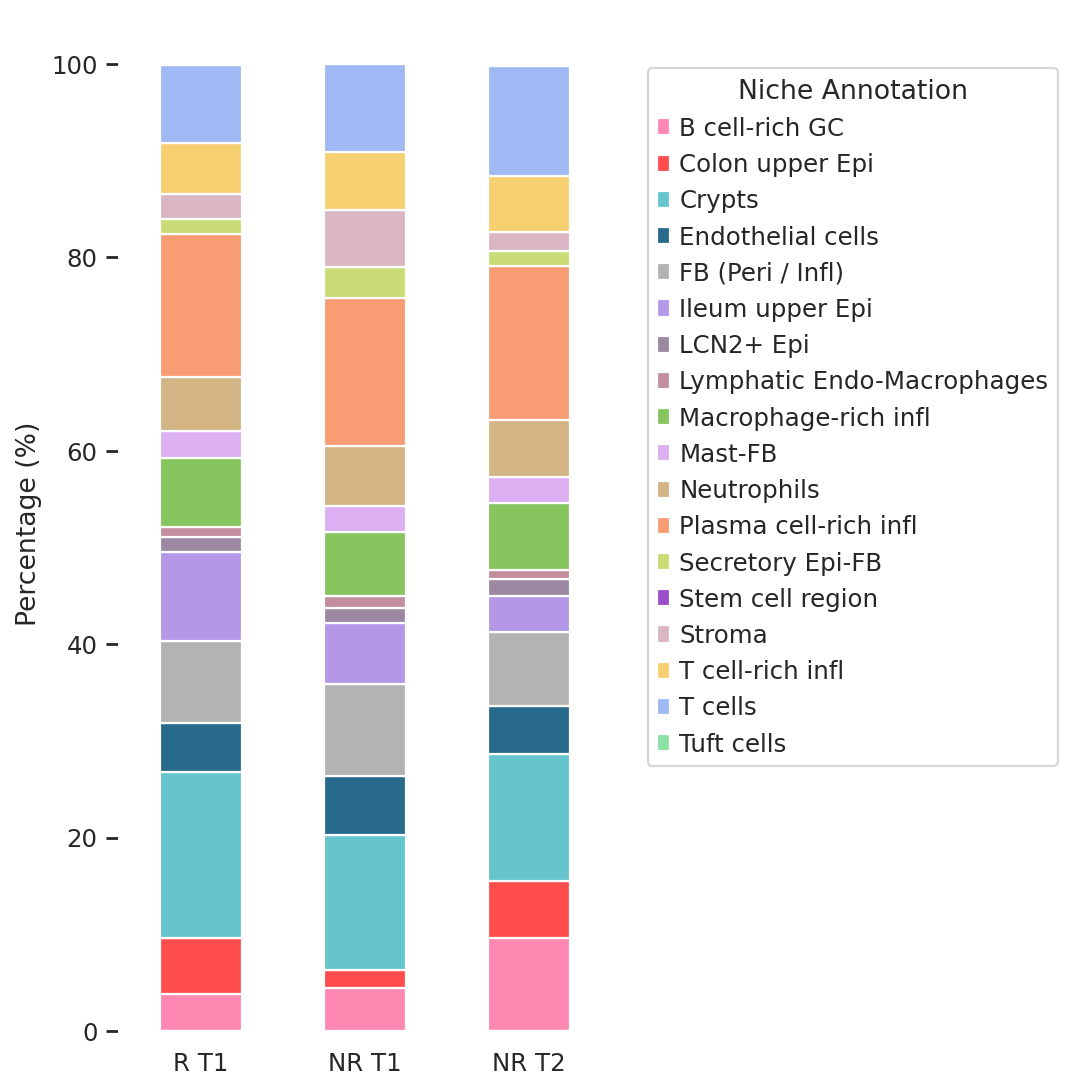

In [141]:
import matplotlib.pyplot as plt
import pandas as pd

# Metadata keys and latent cluster
metadata_keys = ['response_group', 'time_point']
latent_cluster_key = 'niche_annotation'

# ---------- CREATE CONDITION LABEL ----------
# Combine response_group and time_point into a single string label
model.adata.obs['condition_label'] = (
    model.adata.obs['response_group'].astype(str).map({'Responder':'R', 'Non-Responder':'NR'}) + ' ' +
    model.adata.obs['time_point'].astype(str).map({'before_treatment':'T1', 'during_treatment':'T2'})
)


# ---------- COMPUTE NICHE COMPOSITION ----------
df_counts = model.adata.obs.groupby(['condition_label', latent_cluster_key]).size().unstack(fill_value=0)
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

# ---------- SUBSET TO 3 SPECIFIC CONDITIONS ----------
selected_conditions = ['R T1', 'NR T1', 'NR T2']
df_plot = df_percent.loc[selected_conditions]

# ---------- PLOT ----------
fig, ax = plt.subplots(figsize=(7, 7), facecolor='white')

# Use your custom palette
colors = [cluster_colors[niche] for niche in df_plot.columns]

df_plot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors
)

ax.set_ylabel("Percentage (%)")
ax.set_xlabel("")
ax.set_xticklabels(selected_conditions, rotation=0)

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
# Increase spine linewidth
#ax.spines['left'].set_linewidth(1.5)
#ax.spines['bottom'].set_linewidth(1.5)
ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(left=True, bottom=False)
#ax.grid(False)
ax.set_facecolor('white')

# ---------- LEGEND ----------
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title=f"Niche Annotation", bbox_to_anchor=(1.05, 0.96), loc='upper left', facecolor='white')

# ---------- SAVE & SHOW ----------
plt.tight_layout()
file_path = f"{figure_folder_path}/niche_composition_3bars.png"
if save_fig:
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()


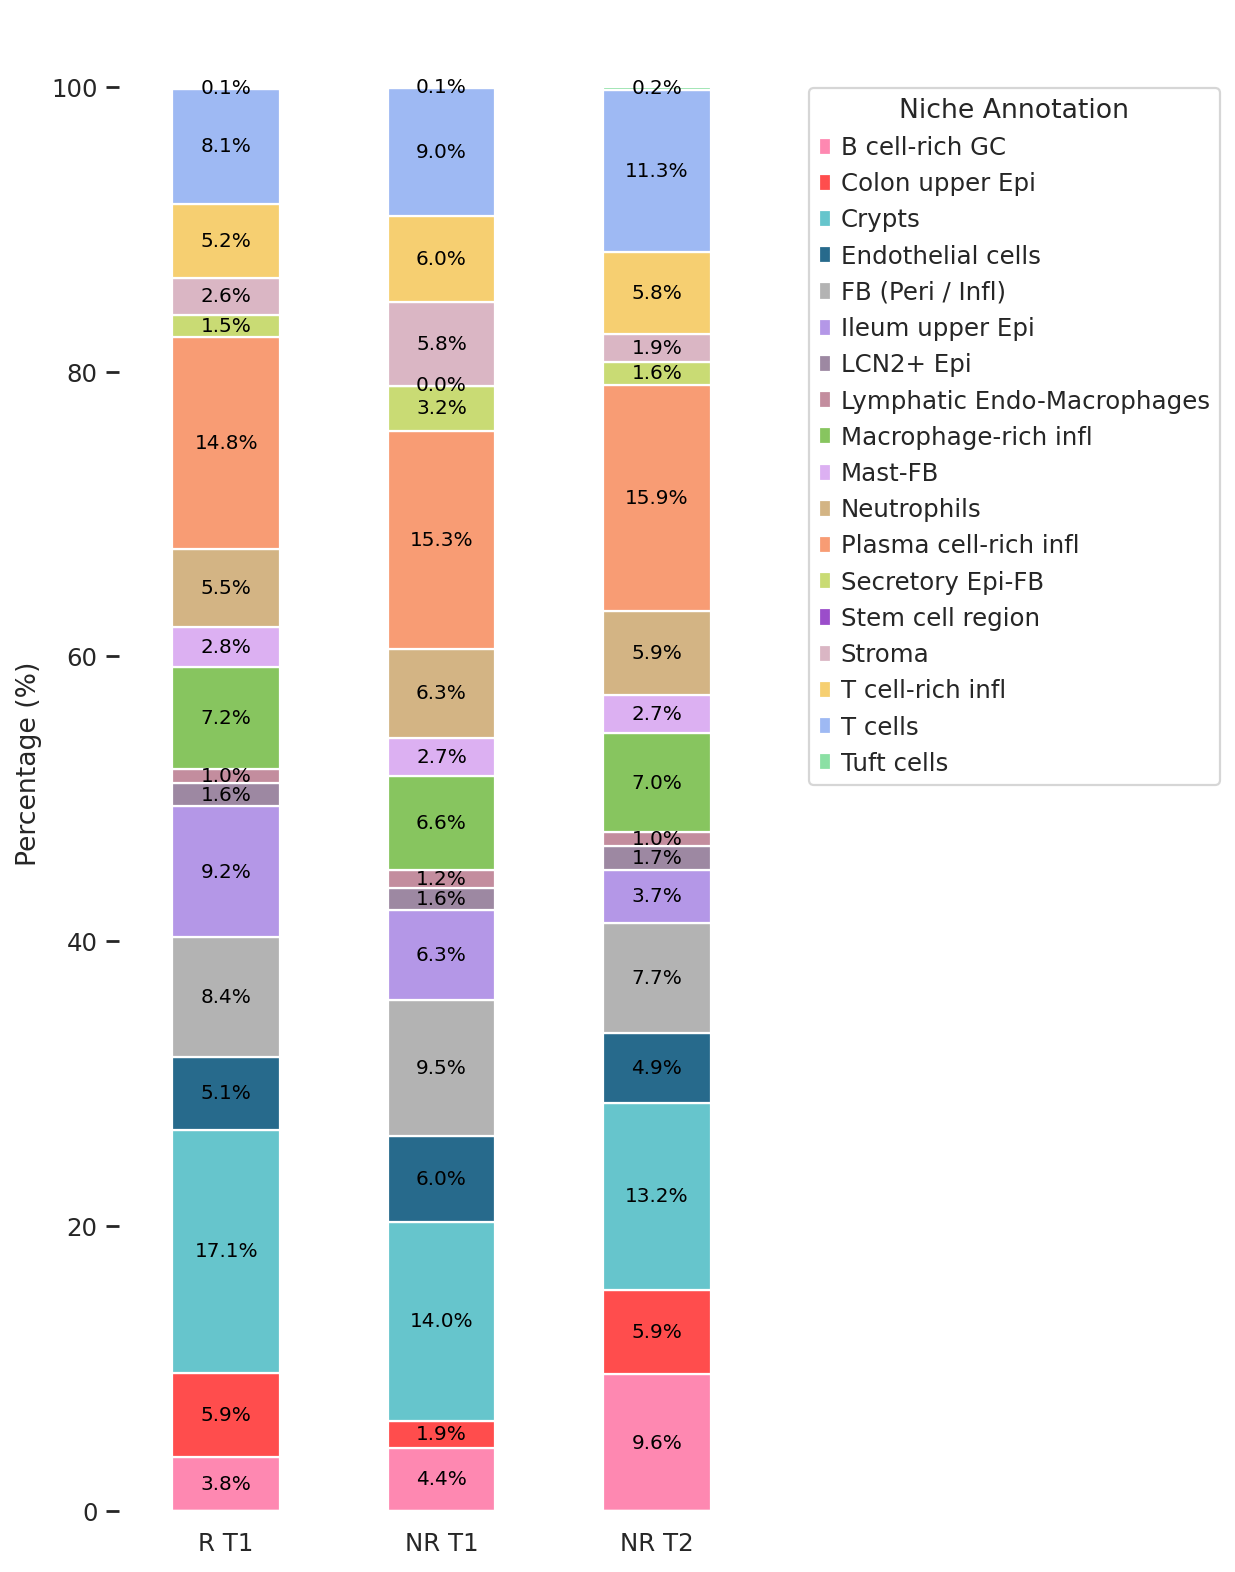

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Metadata keys and latent cluster
metadata_keys = ['response_group', 'time_point']
latent_cluster_key = 'niche_annotation'

# ---------- CREATE CONDITION LABEL ----------
# Combine response_group and time_point into a single string label
model.adata.obs['condition_label'] = (
    model.adata.obs['response_group'].astype(str).map({'Responder':'R', 'Non-Responder':'NR'}) + ' ' +
    model.adata.obs['time_point'].astype(str).map({'before_treatment':'T1', 'during_treatment':'T2'})
)


# ---------- COMPUTE NICHE COMPOSITION ----------
df_counts = model.adata.obs.groupby(['condition_label', latent_cluster_key]).size().unstack(fill_value=0)
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

# ---------- SUBSET TO 3 SPECIFIC CONDITIONS ----------
selected_conditions = ['R T1', 'NR T1', 'NR T2']
df_plot = df_percent.loc[selected_conditions]

# ---------- PLOT ----------
fig, ax = plt.subplots(figsize=(8, 10), facecolor='white')

colors = [cluster_colors[niche] for niche in df_plot.columns]

df_plot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors
)

ax.set_ylabel("Percentage (%)")
ax.set_xlabel("")
ax.set_xticklabels(selected_conditions, rotation=0)

# Show spines clearly
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set_axisbelow(False)

ax.tick_params(left=True, bottom=False, direction='out')
ax.grid(False)
ax.set_facecolor('white')

# ---------- ADD PERCENTAGE LABELS ----------
for i, condition in enumerate(df_plot.index):
    cumulative = 0
    for j, niche in enumerate(df_plot.columns):
        value = df_plot.loc[condition, niche]
        if value > 0:  # only label non-zero segments
            ax.text(
                x=i,
                y=cumulative + value / 2,  # place in the middle of the bar segment
                s=f"{value:.1f}%",  # format as percentage with 1 decimal
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )
            cumulative += value

# ---------- LEGEND ----------
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title=f"Niche Annotation", bbox_to_anchor=(1.05, 0.96), loc='upper left', facecolor='white')

# ---------- SAVE & SHOW ----------
plt.tight_layout()
file_path = f"{figure_folder_path}/niche_composition_3bars_percentages.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()


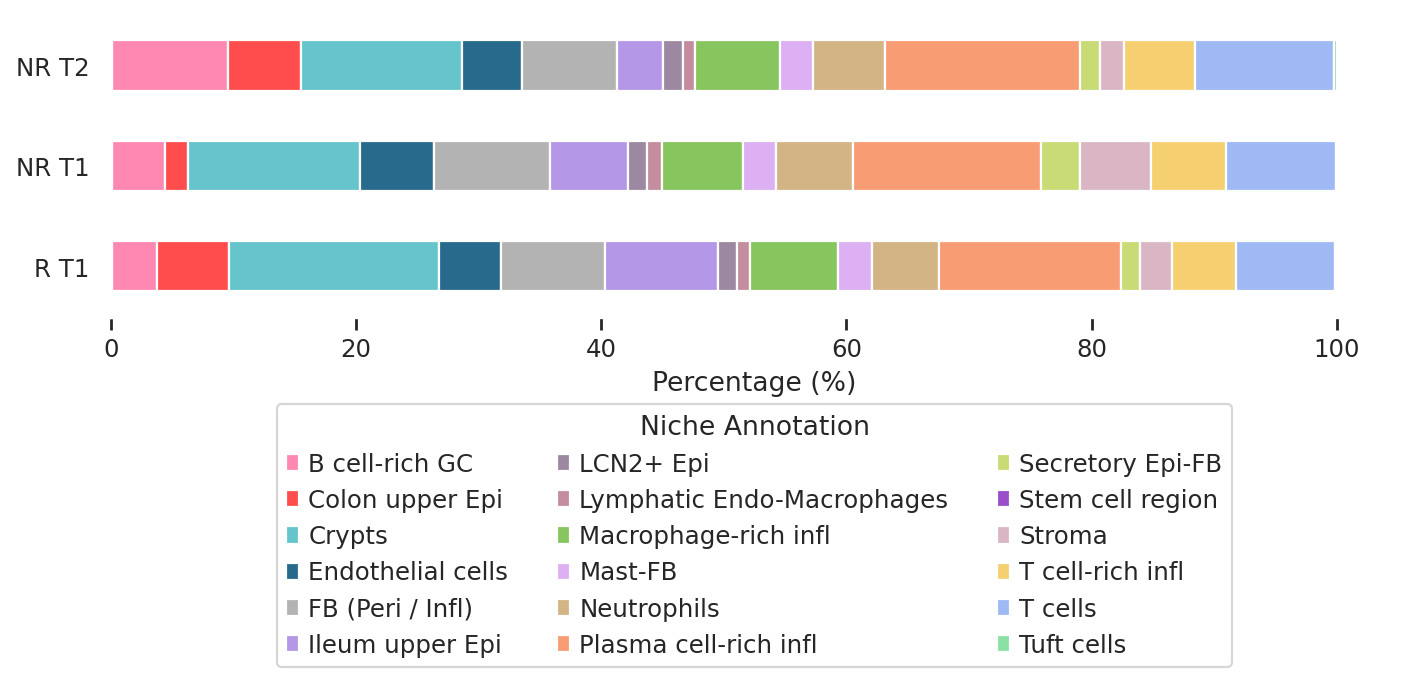

In [140]:
import matplotlib.pyplot as plt
import pandas as pd
# Metadata keys and latent cluster
metadata_keys = ['response_group', 'time_point']
latent_cluster_key = 'niche_annotation'
# ---------- CREATE CONDITION LABEL ----------
# Combine response_group and time_point into a single string label
model.adata.obs['condition_label'] = (
    model.adata.obs['response_group'].astype(str).map({'Responder':'R', 'Non-Responder':'NR'}) + ' ' +
    model.adata.obs['time_point'].astype(str).map({'before_treatment':'T1', 'during_treatment':'T2'})
)
# ---------- COMPUTE NICHE COMPOSITION ----------
df_counts = model.adata.obs.groupby(['condition_label', latent_cluster_key]).size().unstack(fill_value=0)
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100
# ---------- SUBSET TO 3 SPECIFIC CONDITIONS ----------
selected_conditions = ['R T1', 'NR T1', 'NR T2']
df_plot = df_percent.loc[selected_conditions]
# ---------- PLOT ----------
fig, ax = plt.subplots(figsize=(9, 5), facecolor='white')
# Use your custom palette
colors = [cluster_colors[niche] for niche in df_plot.columns]
df_plot.plot(
    kind='barh',  # Changed to horizontal bar plot
    stacked=True,
    ax=ax,
    color=colors
)
ax.set_xlabel("Percentage (%)")  # Swapped xlabel and ylabel
ax.set_ylabel("")
ax.set_yticklabels(selected_conditions, rotation=0)  # Changed to yticklabels
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Increase spine linewidth
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.5)  # Changed to x-axis grid
ax.tick_params(left=False, bottom=True)  # Swapped tick params
ax.set_facecolor('white')
# ---------- LEGEND ----------
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Niche Annotation", 
          loc='upper center', bbox_to_anchor=(0.5, -0.25
                                             ),  # Positioned below plot
          ncol=3, facecolor='white', frameon=True)  # Multiple columns for better fit
# ---------- SAVE & SHOW ----------
plt.tight_layout()
file_path = f"{figure_folder_path}/niche_composition_3bars.png"
if save_fig:
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
plt.show()

#### Differential GPs

In [27]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 216.
Number of active gene programs: 141.


In [28]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

gp_name  all_gp_idx  gp_active  \
0                 CD8A_ligand_receptor_GP           0       True   
1  COMPLEX:IL12B_IL23A_ligand_receptor_GP           1       True   
2                 FRZB_ligand_receptor_GP           2       True   
3                  KIT_ligand_receptor_GP           3       True   
4             TNFRSF1A_ligand_receptor_GP           4       True   

   active_gp_idx  n_source_genes  n_non_zero_source_genes  n_target_genes  \
0              0               1                        1               1   
1              1               2                        2               1   
2              2               1                        1               1   
3              3               1                        1               1   
4              4               1                        1               1   

   n_non_zero_target_genes gp_source_genes gp_target_genes  \
0                        1          [CD8A]       [CEACAM5]   
1                        1  [IL23A, IL12B]         [IL23R]   
2                        1          [FRZB]         [WNT5A]   
3                        1           [KIT]          [IL7R]   
4                        1      [TNFRSF1A]           [TNF]   

  gp_source_genes_weights gp_target_genes_weights gp_source_genes_importances  \
0                [1.6471]               [-2.5033]                    [0.3968]   
1        [0.0387, 0.0018]                 [0.017]             [0.6733, 0.031]   
2                [2.1633]                [4.4295]                    [0.3281]   
3               [-1.3046]               [-3.2141]                    [0.2887]   
4                [7.6217]               [-0.4053]                    [0.9495]   

  gp_target_genes_importances  
0                    [0.6032]  
1                    [0.2958]  
2                    [0.6719]  
3                    [0.7113]  
4                    [0.0505]

In [22]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [29]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

category                          gene_program      p_h0      p_h1  \
0         16                           Add-on_9_GP  1.000000  0.000000   
1         12                          Add-on_84_GP  0.001117  0.998883   
2          5                          Add-on_46_GP  0.998802  0.001198   
3         11                          Add-on_76_GP  0.997941  0.002059   
4         15                          Add-on_88_GP  0.996861  0.003139   
..       ...                                   ...       ...       ...   
125        4   C1QA_ligand_receptor_target_gene_GP  0.909996  0.090004   
126        1                      CSF2_combined_GP  0.909715  0.090285   
127       18                          Add-on_45_GP  0.090431  0.909569   
128        1  EPCAM_ligand_receptor_target_gene_GP  0.909410  0.090590   
129        7               FRZB_ligand_receptor_GP  0.090990  0.909010   

     log_bayes_factor  
0           27.631021  
1           -6.796125  
2            6.726156  
3            6.183589  
4            5.760793  
..                ...  
125          2.313580  
126          2.310158  
127         -2.308382  
128          2.306448  
129         -2.301611  

[130 rows x 5 columns]

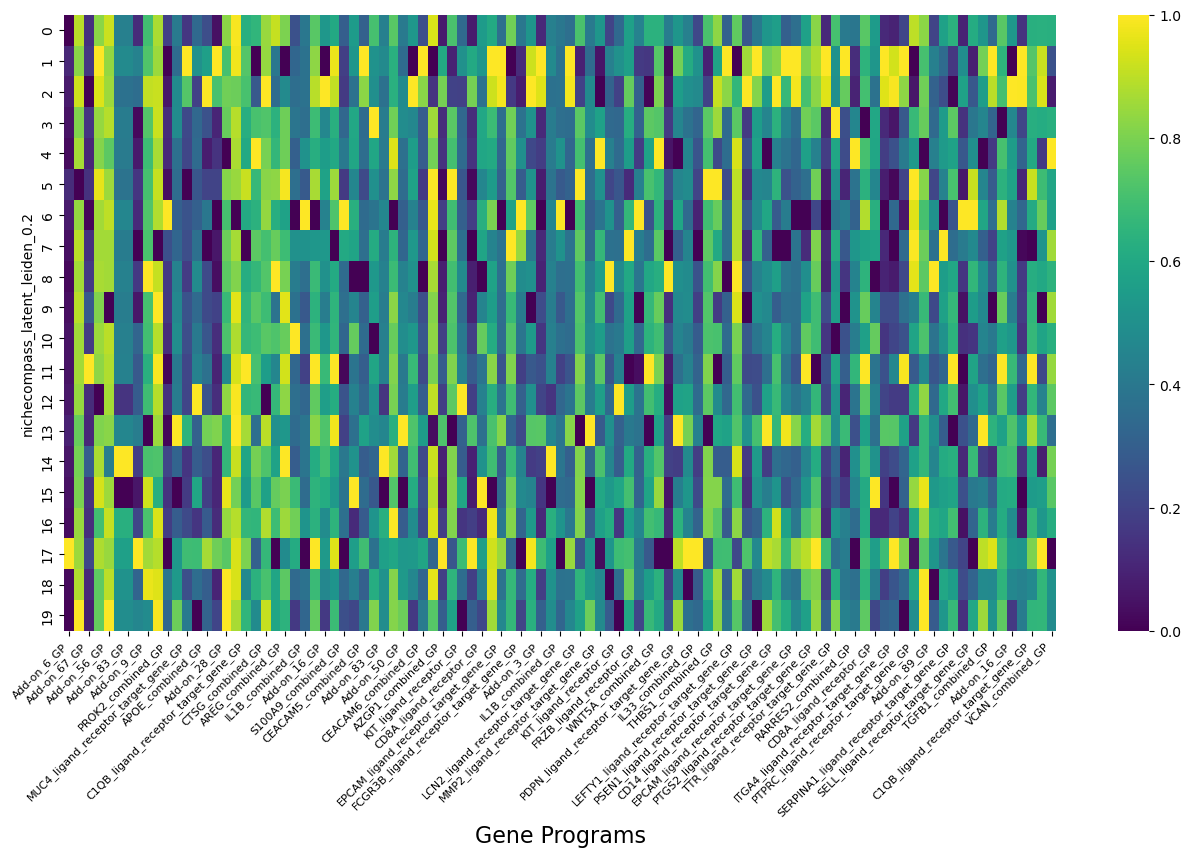

In [19]:
# Visualize GP activities of enriched GPs across niches
enriched_gps = list(model.adata.uns[differential_gp_test_results_key]['gene_program'])
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [30]:
df = model.adata.uns[differential_gp_test_results_key]

# Filter out Add-on gene programs
df_filtered = df[~df["gene_program"].str.startswith("Add-on")]

# 5 lowest p_h0
lowest_ph0 = df_filtered.sort_values("p_h0", ascending=True).head(5)

# 5 lowest p_h1
lowest_ph1 = df_filtered.sort_values("p_h1", ascending=True).head(5)

print("Lowest p_h0:\n", lowest_ph0[["category", "gene_program", "p_h0", "p_h1", "log_bayes_factor"]])
print("\nLowest p_h1:\n", lowest_ph1[["category", "gene_program", "p_h0", "p_h1", "log_bayes_factor"]])

Lowest p_h0:
    category                            gene_program      p_h0      p_h1  \
13       12                  KIT_ligand_receptor_GP  0.017422  0.982578   
18       10                     CEACAM6_combined_GP  0.021633  0.978367   
19       10  CEACAM1_ligand_receptor_target_gene_GP  0.022129  0.977871   
20       19     C1QA_ligand_receptor_target_gene_GP  0.022686  0.977314   
24       19                       CD209_combined_GP  0.029203  0.970797   

    log_bayes_factor  
13         -4.032427  
18         -3.811642  
19         -3.788484  
20         -3.763065  
24         -3.503861  

Lowest p_h1:
    category                            gene_program      p_h0      p_h1  \
6        19     C1QB_ligand_receptor_target_gene_GP  0.995387  0.004613   
8        10  CEACAM7_ligand_receptor_target_gene_GP  0.991286  0.008714   
11       19     CD14_ligand_receptor_target_gene_GP  0.984422  0.015578   
12       19   IFITM1_ligand_receptor_target_gene_GP  0.983332  0.016668   
16     

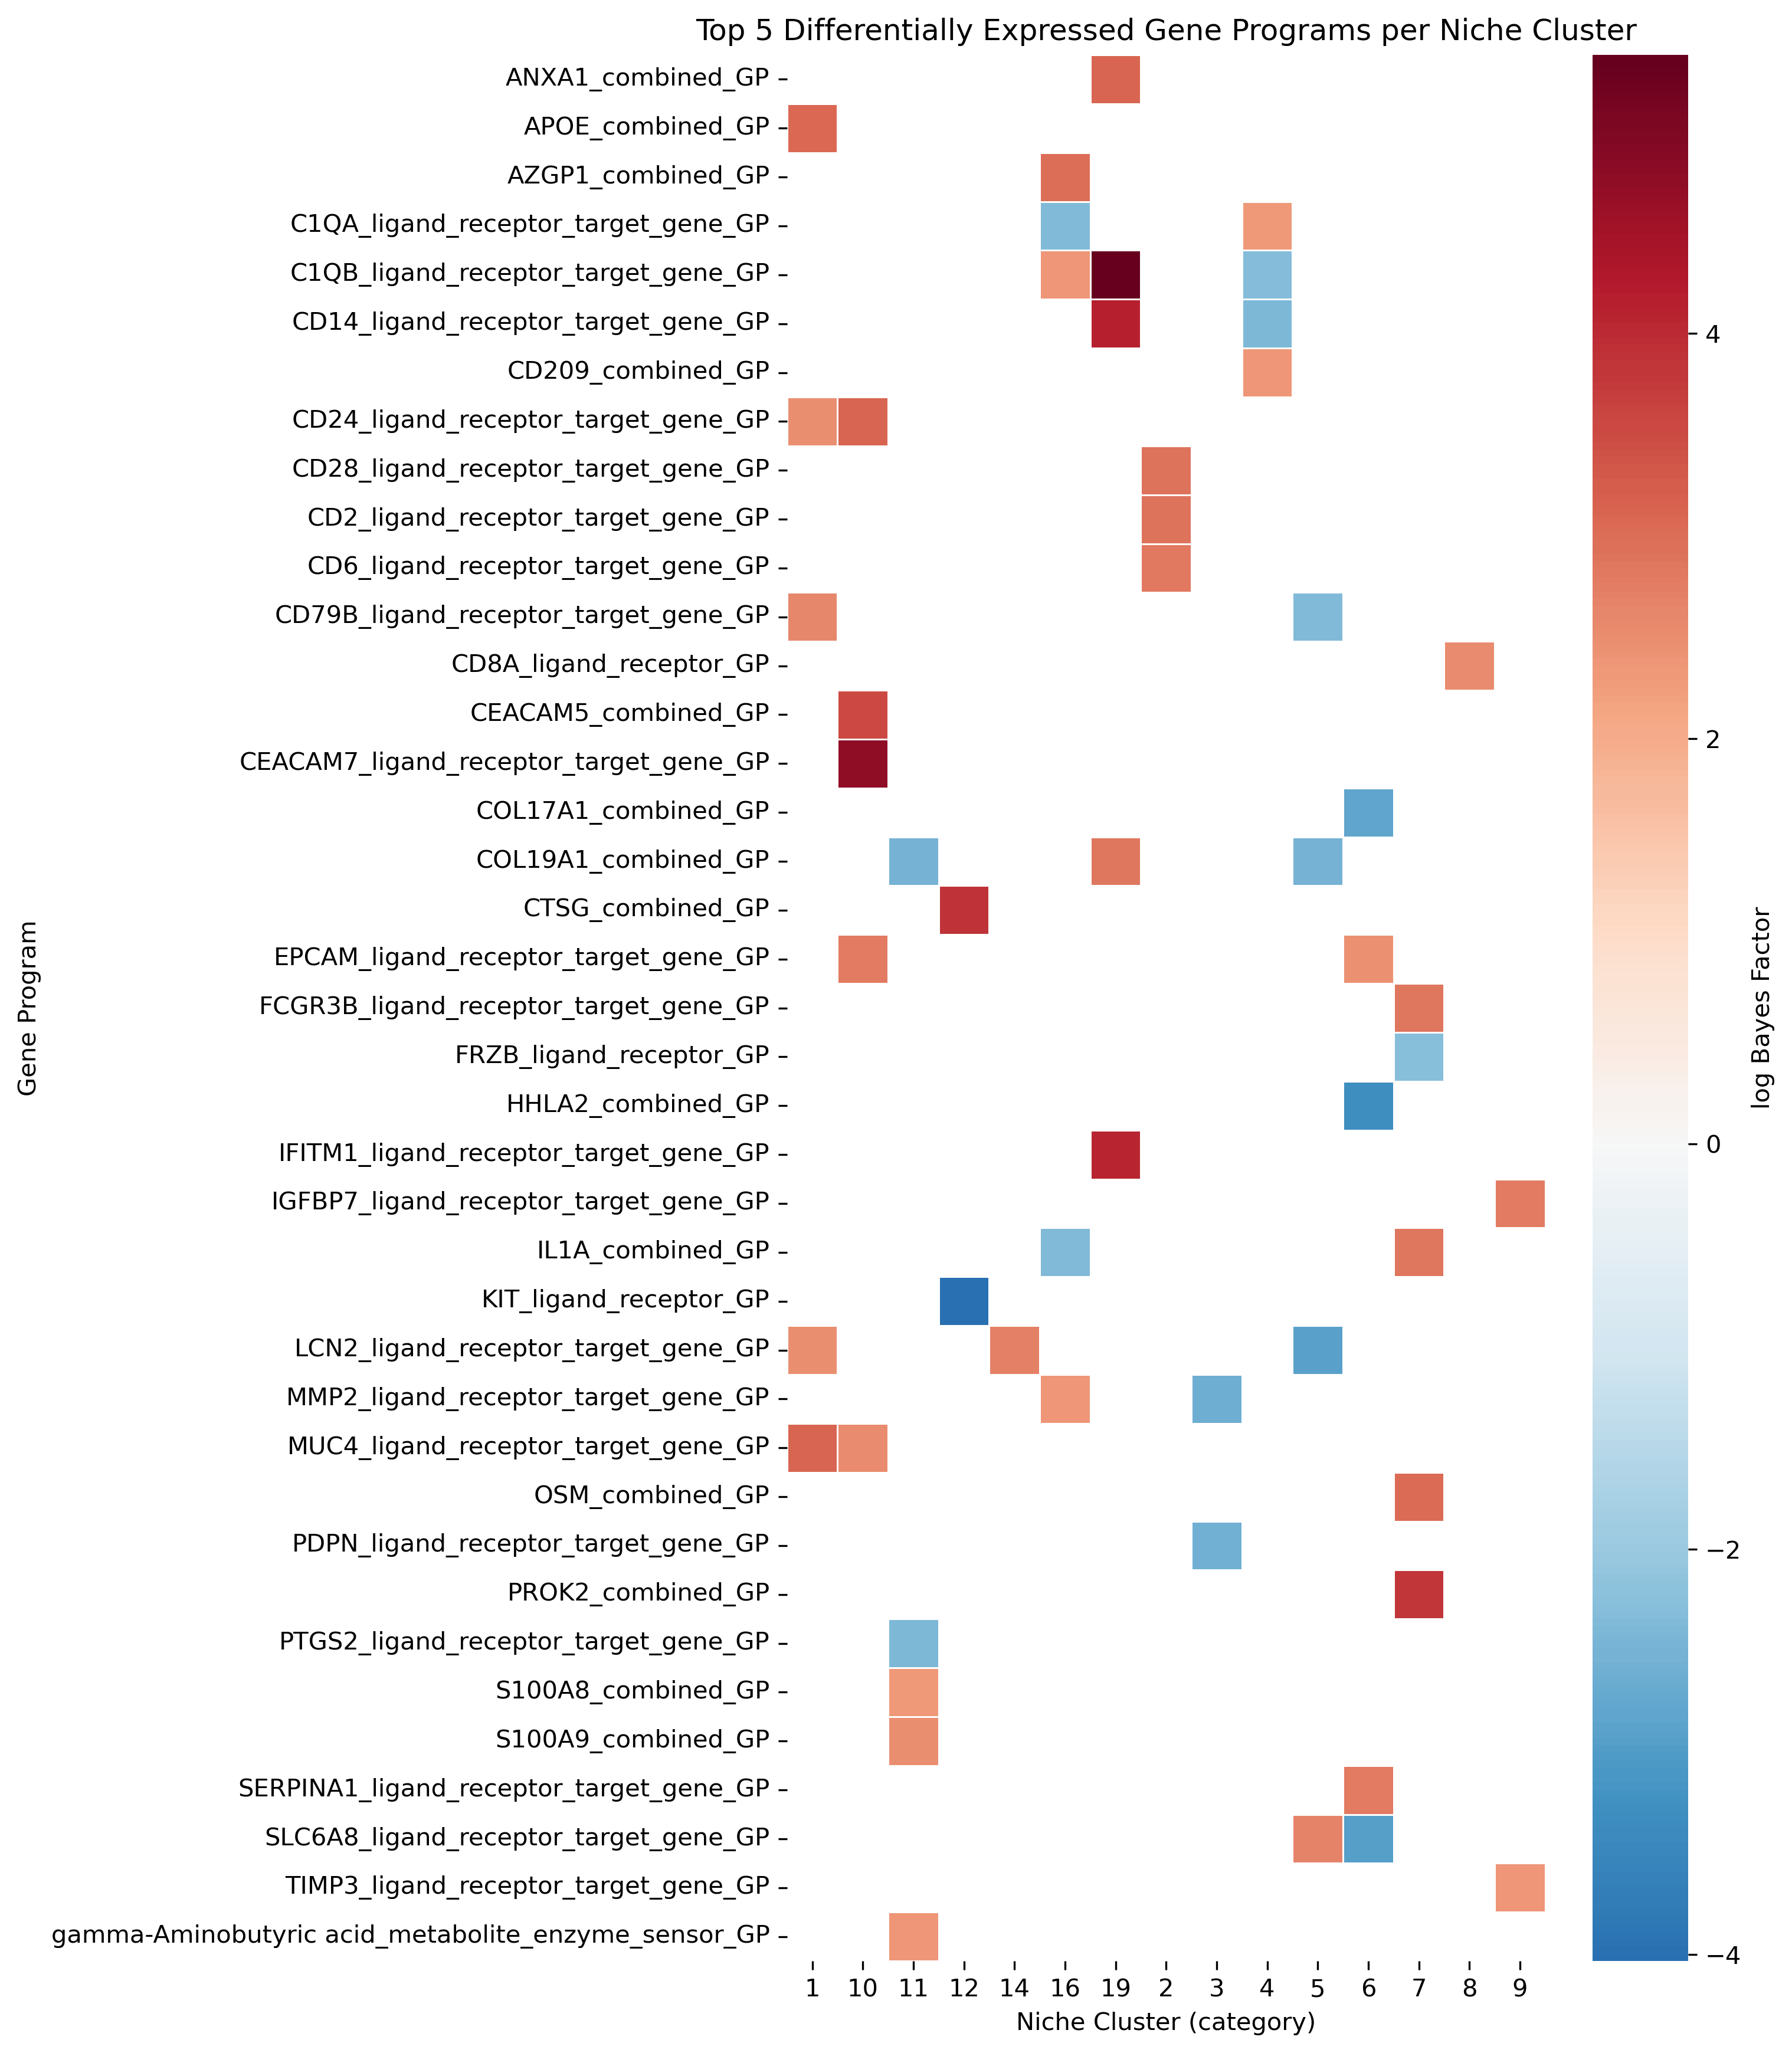

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results table
df = model.adata.uns[differential_gp_test_results_key]

# Filter out "Add-on" gene programs
df_filtered = df[~df["gene_program"].str.startswith("Add-on")]

# For each niche cluster (category), get the top N most differentially expressed programs by p_h1
top_n = 5  # change to any number of top gene programs you want
top_programs_per_cluster = (
    df_filtered
    .sort_values(["category", "p_h1"], ascending=[True, True])
    .groupby("category")
    .head(top_n)
)

# Pivot for heatmap — use log_bayes_factor (or -log10(p_h1)) as effect size
heatmap_data = top_programs_per_cluster.pivot(
    index="gene_program", columns="category", values="log_bayes_factor"
)

# Sort rows and columns for nicer display
heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)

# Plot heatmap
plt.figure(figsize=(10, max(6, 0.3 * len(heatmap_data))))
sns.heatmap(
    heatmap_data,
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "log Bayes Factor"},
    linewidths=0.3,
)
plt.title(f"Top {top_n} Differentially Expressed Gene Programs per Niche Cluster")
plt.xlabel("Niche Cluster (category)")
plt.ylabel("Gene Program")
plt.tight_layout()
plt.show()


In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0] if selected_cats else 'None'}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### Cell-Cell Communication

In [21]:
gp_name = "SERPINA1_ligand_receptor_target_gene_GP"

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(10, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )